<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week5.do.txt --no_mako -->
<!-- dom:TITLE: February 12-16: Advanced machine learning and data analysis for the physical sciences -->

# February 12-16: Advanced machine learning and data analysis for the physical sciences
**Morten Hjorth-Jensen**, Department of Physics and Center for Computing in Science Education, University of Oslo, Norway and Department of Physics and Astronomy and Facility for Rare Isotope Beams, Michigan State University, East Lansing, Michigan, USA

Date: **February 12-16, 2023**

## Plans for February 12-16

* Basics and mathematics of Convolutional  Neural Networks.

* Reading recommendations:

a. For neural networks we recommend Goodfellow et al chapters 6 and 7. For CNNs, see Goodfellow et al chapter 9. See also chapter 11 and 12 on practicalities and applications

b. Reading suggestions for implementation of CNNs: [Rashcka et al.'s chapter 14](https://github.com/rasbt/machine-learning-book/tree/main/ch14). The jupyter-notebook for this chapter is available from Rachska's GitHub site. It is also sent separately to you all.

## Video lectures on CNNs
**Excellent lectures on CNNs and Neural Networks.**

* [Video on Deep Learning](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

* [Video  on Convolutional Neural Networks from MIT](https://www.youtube.com/watch?v=iaSUYvmCekI&ab_channel=AlexanderAmini)

* [Video on CNNs from Stanford](https://www.youtube.com/watch?v=bNb2fEVKeEo&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk&index=6&ab_channel=StanfordUniversitySchoolofEngineering)

## Convolutional Neural Networks (recognizing images)

Convolutional neural networks (CNNs) were developed during the last
decade of the previous century, with a focus on character recognition
tasks. Nowadays, CNNs are a central element in the spectacular success
of deep learning methods. The success in for example image
classifications have made them a central tool for most machine
learning practitioners.

CNNs are very similar to ordinary Neural Networks.
They are made up of neurons that have learnable weights and
biases. Each neuron receives some inputs, performs a dot product and
optionally follows it with a non-linearity. The whole network still
expresses a single differentiable score function: from the raw image
pixels on one end to class scores at the other. And they still have a
loss function (for example Softmax) on the last (fully-connected) layer
and all the tips/tricks we developed for learning regular Neural
Networks still apply (back propagation, gradient descent etc etc).

## What is the Difference

**CNN architectures make the explicit assumption that
the inputs are images, which allows us to encode certain properties
into the architecture. These then make the forward function more
efficient to implement and vastly reduce the amount of parameters in
the network.**

## Neural Networks vs CNNs

Neural networks are defined as **affine transformations**, that is 
a vector is received as input and is multiplied with a matrix of so-called weights (our unknown paramters) to produce an
output (to which a bias vector is usually added before passing the result
through a nonlinear activation function). This is applicable to any type of input, be it an
image, a sound clip or an unordered collection of features: whatever their
dimensionality, their representation can always be flattened into a vector
before the transformation.

## Why CNNS for images, sound files, medical images from CT scans etc?

However, when we consider images, sound clips and many other similar kinds of data, these data  have an intrinsic
structure. More formally, they share these important properties:
* They are stored as multi-dimensional arrays (think of the pixels of a figure) .

* They feature one or more axes for which ordering matters (e.g., width and height axes for an image, time axis for a sound clip).

* One axis, called the channel axis, is used to access different views of the data (e.g., the red, green and blue channels of a color image, or the left and right channels of a stereo audio track).

These properties are not exploited when an affine transformation is applied; in
fact, all the axes are treated in the same way and the topological information
is not taken into account. Still, taking advantage of the implicit structure of
the data may prove very handy in solving some tasks, like computer vision and
speech recognition, and in these cases it would be best to preserve it. This is
where discrete convolutions come into play.

A discrete convolution is a linear transformation that preserves this notion of
ordering. It is sparse (only a few input units contribute to a given output
unit) and reuses parameters (the same weights are applied to multiple locations
in the input).

## Regular NNs don’t scale well to full images

As an example, consider
an image of size $32\times 32\times 3$ (32 wide, 32 high, 3 color channels), so a
single fully-connected neuron in a first hidden layer of a regular
Neural Network would have $32\times 32\times 3 = 3072$ weights. This amount still
seems manageable, but clearly this fully-connected structure does not
scale to larger images. For example, an image of more respectable
size, say $200\times 200\times 3$, would lead to neurons that have 
$200\times 200\times 3 = 120,000$ weights. 

We could have
several such neurons, and the parameters would add up quickly! Clearly,
this full connectivity is wasteful and the huge number of parameters
would quickly lead to possible overfitting.

<!-- dom:FIGURE: [figslides/nn.jpeg, width=500 frac=0.6]  A regular 3-layer Neural Network. -->
<!-- begin figure -->

<img src="figslides/nn.jpeg" width="500"><p style="font-size: 0.9em"><i>Figure 1: A regular 3-layer Neural Network.</i></p>
<!-- end figure -->

## 3D volumes of neurons

Convolutional Neural Networks take advantage of the fact that the
input consists of images and they constrain the architecture in a more
sensible way. 

In particular, unlike a regular Neural Network, the
layers of a CNN have neurons arranged in 3 dimensions: width,
height, depth. (Note that the word depth here refers to the third
dimension of an activation volume, not to the depth of a full Neural
Network, which can refer to the total number of layers in a network.)

To understand it better, the above example of an image 
with an input volume of
activations has dimensions $32\times 32\times 3$ (width, height,
depth respectively). 

The neurons in a layer will
only be connected to a small region of the layer before it, instead of
all of the neurons in a fully-connected manner. Moreover, the final
output layer could  for this specific image have dimensions $1\times 1 \times 10$, 
because by the
end of the CNN architecture we will reduce the full image into a
single vector of class scores, arranged along the depth
dimension. 

<!-- dom:FIGURE: [figslides/cnn.jpeg, width=500 frac=0.6]  A CNN arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers. Every layer of a CNN transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (Red, Green, Blue channels). -->
<!-- begin figure -->

<img src="figslides/cnn.jpeg" width="500"><p style="font-size: 0.9em"><i>Figure 1: A CNN arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers. Every layer of a CNN transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (Red, Green, Blue channels).</i></p>
<!-- end figure -->

## More on Dimensionalities

In fields like signal processing (and imaging as well), one designs
so-called filters. These filters are defined by the convolutions and
are often hand-crafted. One may specify filters for smoothing, edge
detection, frequency reshaping, and similar operations. However with
neural networks the idea is to automatically learn the filters and use
many of them in conjunction with non-linear operations (activation
functions).

As an example consider a neural network operating on sound sequence
data.  Assume that we an input vector $\boldsymbol{x}$ of length $d=10^6$.  We
construct then a neural network with onle hidden layer only with
$10^4$ nodes. This means that we will have a weight matrix with
$10^4\times 10^6=10^{10}$ weights to be determined, together with $10^4$ biases.

Assume furthermore that we have an output layer which is meant to train whether the sound sequence represents a human voice (true) or something else (false).
It means that we have only one output node. But since this output node connects to $10^4$ nodes in the hidden layer, there are in total $10^4$ weights to be determined for the output layer, plus one bias. In total we have

$$
\mathrm{NumberParameters}=10^{10}+10^4+10^4+1 \approx 10^{10},
$$

that is ten billion parameters to determine.

## Further remarks

The main principles that justify convolutions is locality of
information and repetion of patterns within the signal. Sound samples
of the input in adjacent spots are much more likely to affect each
other than those that are very far away. Similarly, sounds are
repeated in multiple times in the signal. While slightly simplistic,
reasoning about such a sound example demonstrates this. The same
principles then apply to images and other similar data.

## Layers used to build CNNs

A simple CNN is a sequence of layers, and every layer of a CNN
transforms one volume of activations to another through a
differentiable function. We use three main types of layers to build
CNN architectures: Convolutional Layer, Pooling Layer, and
Fully-Connected Layer (exactly as seen in regular Neural Networks). We
will stack these layers to form a full CNN architecture.

A simple CNN for image classification could have the architecture:

* **INPUT** ($32\times 32 \times 3$) will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.

* **CONV** (convolutional )layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as $[32\times 32\times 12]$ if we decided to use 12 filters.

* **RELU** layer will apply an elementwise activation function, such as the $max(0,x)$ thresholding at zero. This leaves the size of the volume unchanged ($[32\times 32\times 12]$).

* **POOL** (pooling) layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as $[16\times 16\times 12]$.

* **FC** (i.e. fully-connected) layer will compute the class scores, resulting in volume of size $[1\times 1\times 10]$, where each of the 10 numbers correspond to a class score, such as among the 10 categories of the MNIST images we considered above . As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

## Transforming images

CNNs transform the original image layer by layer from the original
pixel values to the final class scores. 

Observe that some layers contain
parameters and other don’t. In particular, the CNN layers perform
transformations that are a function of not only the activations in the
input volume, but also of the parameters (the weights and biases of
the neurons). On the other hand, the RELU/POOL layers will implement a
fixed function. The parameters in the CONV/FC layers will be trained
with gradient descent so that the class scores that the CNN computes
are consistent with the labels in the training set for each image.

## CNNs in brief

In summary:

* A CNN architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)

* There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)

* Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function

* Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)

* Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)

## A deep CNN model ([From Raschka et al](https://github.com/rasbt/machine-learning-book))

<!-- dom:FIGURE: [figslides/deepcnn.png, width=500 frac=0.67]  A deep CNN -->
<!-- begin figure -->

<img src="figslides/deepcnn.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: A deep CNN</i></p>
<!-- end figure -->

## Key Idea

A dense neural network is representd by an affine operation (like matrix-matrix multiplication) where all parameters are included.

The key idea in CNNs for say imaging is that in images neighbor pixels tend to be related! So we connect
only neighboring neurons in the input instead of connecting all with the first hidden layer.

We say we perform a filtering (convolution is the mathematical operation).

## Mathematics of CNNs

The mathematics of CNNs is based on the mathematical operation of
**convolution**.  In mathematics (in particular in functional analysis),
convolution is represented by mathematical operations (integration,
summation etc) on two functions in order to produce a third function
that expresses how the shape of one gets modified by the other.
Convolution has a plethora of applications in a variety of
disciplines, spanning from statistics to signal processing, computer
vision, solutions of differential equations,linear algebra,
engineering, and yes, machine learning.

Mathematically, convolution is defined as follows (one-dimensional example):
Let us define a continuous function $y(t)$ given by

$$
y(t) = \int x(a) w(t-a) da,
$$

where $x(a)$ represents a so-called input and $w(t-a)$ is normally called the weight function or kernel.

The above integral is written in  a more compact form as

$$
y(t) = \left(x * w\right)(t).
$$

The discretized version reads

$$
y(t) = \sum_{a=-\infty}^{a=\infty}x(a)w(t-a).
$$

Computing the inverse of the above convolution operations is known as deconvolution and the process is commutative.

How can we use this? And what does it mean? Let us study some familiar examples first.

## Convolution Examples: Polynomial multiplication

Our first example is that of a multiplication between two polynomials,
which we will rewrite in terms of the mathematics of convolution. In
the final stage, since the problem here is a discrete one, we will
recast the final expression in terms of a matrix-vector
multiplication, where the matrix is a so-called [Toeplitz matrix
](https://link.springer.com/book/10.1007/978-93-86279-04-0).

Let us look a the following polynomials to second and third order, respectively:

$$
p(t) = \alpha_0+\alpha_1 t+\alpha_2 t^2,
$$

and

$$
s(t) = \beta_0+\beta_1 t+\beta_2 t^2+\beta_3 t^3.
$$

The polynomial multiplication gives us a new polynomial of degree $5$

$$
z(t) = \delta_0+\delta_1 t+\delta_2 t^2+\delta_3 t^3+\delta_4 t^4+\delta_5 t^5.
$$

## Efficient Polynomial Multiplication

Computing polynomial products can be implemented efficiently if we rewrite the more brute force multiplications using convolution.
We note first that the new coefficients are given as

$$
\begin{split}
\delta_0=&\alpha_0\beta_0\\
\delta_1=&\alpha_1\beta_0+\alpha_0\beta_1\\
\delta_2=&\alpha_0\beta_2+\alpha_1\beta_1+\alpha_2\beta_0\\
\delta_3=&\alpha_1\beta_2+\alpha_2\beta_1+\alpha_0\beta_3\\
\delta_4=&\alpha_2\beta_2+\alpha_1\beta_3\\
\delta_5=&\alpha_2\beta_3.\\
\end{split}
$$

We note that $\alpha_i=0$ except for $i\in \left\{0,1,2\right\}$ and $\beta_i=0$ except for $i\in\left\{0,1,2,3\right\}$.

We can then rewrite the coefficients $\delta_j$ using a discrete convolution as

$$
\delta_j = \sum_{i=-\infty}^{i=\infty}\alpha_i\beta_{j-i}=(\alpha * \beta)_j,
$$

or as a double sum with restriction $l=i+j$

$$
\delta_l = \sum_{ij}\alpha_i\beta_{j}.
$$

## Further simplification

Although we may have redundant operations with some few zeros for $\beta_i$, we can rewrite the above sum in a more compact way as

$$
\delta_i = \sum_{k=0}^{k=m-1}\alpha_k\beta_{i},
$$

where $m=3$ in our case, the maximum length of the vector $\alpha$. Note that the vector $\boldsymbol{\beta}$ has length $n=4$.

## A more efficient way of coding the above Convolution

Since we only have a finite number of $\alpha$ and $\beta$ values
which are non-zero, we can rewrite the above convolution expressions
as a matrix-vector multiplication

$$
\boldsymbol{\delta}=\begin{bmatrix}\alpha_0 & 0 & 0 & 0 \\
                            \alpha_1 & \alpha_0 & 0 & 0 \\
			    \alpha_2 & \alpha_1 & \alpha_0 & 0 \\
			    0 & \alpha_2 & \alpha_1 & \alpha_0 \\
			    0 & 0 & \alpha_2 & \alpha_1 \\
			    0 & 0 & 0 & \alpha_2
			    \end{bmatrix}\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \beta_3\end{bmatrix}.
$$

The process is commutative and we can easily see that we can rewrite the multiplication in terms of  a matrix holding $\beta$ and a vector holding $\alpha$.
In this case we have

$$
\boldsymbol{\delta}=\begin{bmatrix}\beta_0 & 0 & 0  \\
                            \beta_1 & \beta_0 & 0  \\
			    \beta_2 & \beta_1 & \beta_0  \\
			    \beta_3 & \beta_2 & \beta_1 \\
			    0 & \beta_3 & \beta_2 \\
			    0 & 0 & \beta_3
			    \end{bmatrix}\begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \alpha_2\end{bmatrix}.
$$

Note that the use of these matrices is for mathematical purposes only
and not implementation purposes.  When implementing the above equation
we do not encode (and allocate memory) the matrices explicitely.  We
rather code the convolutions in the minimal memory footprint that they
require.

The above matrices are examples of so-called [Toeplitz
matrices](https://link.springer.com/book/10.1007/978-93-86279-04-0). A
Toeplitz matrix is a matrix in which each descending diagonal from
left to right is constant. For instance the last matrix, which we
rewrite as

$$
\boldsymbol{A}=\begin{bmatrix}a_0 & 0 & 0  \\
                            a_1 & a_0 & 0  \\
			    a_2 & a_1 & a_0  \\
			    a_3 & a_2 & a_1 \\
			    0 & a_3 & a_2 \\
			    0 & 0 & a_3
			    \end{bmatrix},
$$

with elements $a_{ii}=a_{i+1,j+1}=a_{i-j}$ is an example of a Toeplitz
matrix. Such a matrix does not need to be a square matrix.  Toeplitz
matrices are also closely connected with Fourier series, because the multiplication operator by a trigonometric
polynomial, compressed to a finite-dimensional space, can be
represented by such a matrix. The example above shows that we can
represent linear convolution as multiplication of a Toeplitz matrix by
a vector.

## Fourier series and Toeplitz matrices

This is an active and ogoing research area concerning CNNs. The following articles may be of interest
1. [Read more about the convolution theorem and Fouriers series](https://www.sciencedirect.com/topics/engineering/convolution-theorem#:~:text=The%20convolution%20theorem%20(together%20with,k%20)%20G%20(%20k%20)%20.)

2. [Fourier Transform Layer](https://www.sciencedirect.com/science/article/pii/S1568494623006257)

## Generalizing the above one-dimensional case

In order to align the above simple case with the more general convolution cases, we rename $\boldsymbol{\alpha}$, whose length is $m=3$, with $\boldsymbol{w}$.
We will interpret $\boldsymbol{w}$ as a weight/filter function with which we want to perform the convolution with an input varibale $\boldsymbol{x}$.
We replace thus $\boldsymbol{\beta}$ with $\boldsymbol{x}$ and $\boldsymbol{\delta}$ with $\boldsymbol{s}$ and have

$$
s(i) \left(x*w\right)(i)= \sum_{k=0}^{k=m-1}w(k)x(i),
$$

where $m=3$ in our case, the maximum length of the vector $\boldsymbol{w}$.
Here the symbol $*$ represents the mathematical operation of convolution.

## Two-dimensional Objects

We are now ready to start studying the discrete convolutions relevant for convolutional neural networks.
We often use convolutions over more than one dimension at a time. If
we have a two-dimensional image $I$ as input, we can have a **filter**
defined by a two-dimensional **kernel** $K$. This leads to an output $Y$

$$
Y(i,j)=(X * W)(i,j) = \sum_m\sum_n X(m,n)W(i-m,j-n).
$$

Convolution is a commutative process, which means we can rewrite this equation as

$$
Y(i,j)=(X * W)(i,j) = \sum_m\sum_n X(i-m,j-n)W(m,n).
$$

Normally the latter is more straightforward to implement in  a machine larning library since there is less variation in the range of values of $m$ and $n$.

Many deep learning libraries implement cross-correlation instead of convolution (although it is referred to s convolution)

$$
Y(i,j)=(X * W)(i,j) = \sum_m\sum_n X(i+m,j+n)W(m,n).
$$

## CNNs in more detail

Let assume we have an input matrix $X$ of dimensionality $3\times 3$
and a $2\times 2$ filter $W$ given by the following matrices

$$
\boldsymbol{X}=\begin{bmatrix}x_{00} & x_{01} & x_{02}  \\
                      x_{10} & x_{11} & x_{12}  \\
	              x_{20} & x_{21} & x_{22} \end{bmatrix},
$$

and

$$
\boldsymbol{W}=\begin{bmatrix}w_{00} & w_{01} \\
	              w_{10} & w_{11}\end{bmatrix}.
$$

We introduce now the hyperparameter $S$ **stride**. Stride represents how the filter $W$ moves the convolution process on the matrix $X$.
We strongly recommend the repository on [Arithmetic of deep learning by Dumoulin and Visin](https://github.com/vdumoulin/conv_arithmetic) 

Here we set the stride equal to $S=1$, which means that, starting with the element $x_{00}$, the filter will act on $2\times 2$ submatrices each time, starting with the upper corner and moving according to the stride value column by column. 

Here we perform the operation

$$
Y_(i,j)=(X * W)(i,j) = \sum_m\sum_n X(i-m,j-n)W(m,n),
$$

and obtain

$$
\boldsymbol{Y}=\begin{bmatrix}x_{00}w_{00}+x_{01}w_{01}+x_{10}w_{10}+x_{11}w_{11} & x_{01}w_{00}+x_{02}w_{01}+x_{11}w_{10}+x_{12}w_{11}  \\
	              x_{10}w_{00}+x_{11}w_{01}+x_{20}w_{10}+x_{21}w_{11} & x_{11}w_{00}+x_{12}w_{01}+x_{21}w_{10}+x_{22}w_{11}\end{bmatrix}.
$$

We can rewrite this operation in terms of a matrix-vector multiplication by defining a new vector where we flatten out the inputs as a vector $\boldsymbol{X}'$ of length $9$ and
a matrix $\boldsymbol{W}'$ with dimension $4\times 9$ as

$$
\boldsymbol{X}'=\begin{bmatrix}x_{00} \\ x_{01} \\ x_{02} \\ x_{10} \\ x_{11} \\ x_{12} \\ x_{20} \\ x_{21} \\ x_{22} \end{bmatrix},
$$

and the new matrix

$$
\boldsymbol{W}'=\begin{bmatrix} w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
                        0  & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 \\
			0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0  \\
                        0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}\end{bmatrix}.
$$

We see easily that performing the matrix-vector multiplication $\boldsymbol{W}'\boldsymbol{X}'$ is the same as the above convolution with stride $S=1$, that is

$$
Y=(\boldsymbol{W}*\boldsymbol{X}),
$$

is now given by $\boldsymbol{W}'\boldsymbol{X}'$ which is a vector of length $4$ instead of the originally resulting  $2\times 2$ output matrix.

## Performing a discrete convolution with padding ([From Raschka et al](https://github.com/rasbt/machine-learning-book))

<!-- dom:FIGURE: [figslides/discreteconv.png, width=500 frac=0.67]  A deep CNN -->
<!-- begin figure -->

<img src="figslides/discreteconv.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: A deep CNN</i></p>
<!-- end figure -->

## Performing a general discrete convolution ([From Raschka et al](https://github.com/rasbt/machine-learning-book))

<!-- dom:FIGURE: [figslides/discreteconv1.png, width=500 frac=0.67]  A deep CNN -->
<!-- begin figure -->

<img src="figslides/discreteconv1.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: A deep CNN</i></p>
<!-- end figure -->

## Set of filters

The collection of kernels/filters $W$ defining a discrete convolution has a shape
corresponding to some permutation of $(n, m, k_1, \ldots, k_N)$, where

$$
\begin{split}
    n &\equiv \text{number of output feature maps},\\
    m &\equiv \text{number of input feature maps},\\
    k_j &\equiv \text{kernel size along axis $j$}.
\end{split}
$$

The following properties affect the output size $o_j$ of a convolutional layer
along axis $j$:

1. $i_j$: input size along axis $j$,

2. $k_j$: kernel/filter size along axis $j$,

3. stride (distance between two consecutive positions of the kernel/filter) along axis $j$,

4. zero padding (number of zeros concatenated at the beginning and at the end of an axis) along axis $j$.

For instance, the above examples shows a  $2\times 2$ kernel/filter $\boldsymbol{W}$  applied to a $3 \times 3$ input padded with a $0 \times 0$
border of zeros using $1 \times 1$ strides.

Note that strides constitute a form of **subsampling**. As an alternative to
being interpreted as a measure of how much the kernel/filter is translated, strides
can also be viewed as how much of the output is retained. For instance, moving
the kernel by hops of two is equivalent to moving the kernel by hops of one but
retaining only odd output elements.

## Pooling

In addition to discrete convolutions themselves, {\em pooling\/} operations
make up another important building block in CNNs. Pooling operations reduce
the size of feature maps by using some function to summarize subregions, such
as taking the average or the maximum value.

Pooling works by sliding a window across the input and feeding the content of
the window to a {\em pooling function}. In some sense, pooling works very much
like a discrete convolution, but replaces the linear combination described by
the kernel with some other function. Poolin
provides an example for average pooling, and 
does the same for max pooling.

The following properties affect the output size $o_j$ of a pooling layer
along axis $j$:

1. $i_j$: input size along axis $j$,

2. $k_j$: pooling window size along axis $j$,

3. $s_j$: stride (distance between two consecutive positions of the pooling window) along axis $j$.

The analysis of the relationship between convolutional layer properties is eased
by the fact that they don't interact across axes, i.e., the choice of kernel
size, stride and zero padding along axis $j$ only affects the output size of
axis $j$. Because of that, we will focus on the following simplified
setting:

1. 2-D discrete convolutions ($N = 2$),

2. square inputs ($i_1 = i_2 = i$),

3. square kernel size ($k_1 = k_2 = k$),

4. same strides along both axes ($s_1 = s_2 = s$),

5. same zero padding along both axes ($p_1 = p_2 = p$).

This facilitates the analysis and the visualization, but keep in mind that the
results outlined here also generalize to the N-D and non-square cases.

## No zero padding, unit strides

The simplest case to analyze is when the kernel just slides across every
position of the input (i.e., $s = 1$ and $p = 0$).

For any $i$ and $k$, and for $s = 1$ and $p = 0$,

$$
o = (i - k) + 1.
$$

## Zero padding, unit strides

To factor in zero padding (i.e., only restricting to $s = 1$), let's consider
its effect on the effective input size: padding with $p$ zeros changes the
effective input size from $i$ to $i + 2p$. In the general case, we can infer the following
relationship

For any $i$, $k$ and $p$, and for $s = 1$,

$$
o = (i - k) + 2p + 1.
$$

## Half (same) padding

Having the output size be the same as the input size (i.e., $o = i$) can be a
desirable property:

For any $i$ and for $k$ odd ($k = 2n + 1, \quad n \in \mathbb{N}$), $s = 1$ and
$p = \lfloor k / 2 \rfloor = n$,

$$
\begin{split}
    o &= i + 2 \lfloor k / 2 \rfloor - (k - 1) \\
      &= i + 2n - 2n \\
      &= i.
\end{split}
$$

## Full padding

While convolving a kernel generally decreases the output size with
respect to the input size, sometimes the opposite is required. This can be
achieved with proper zero padding:

For any $i$ and $k$, and for $p = k - 1$ and $s = 1$,

$$
\begin{split}
    o &= i + 2(k - 1) - (k - 1) \\
      &= i + (k - 1).
\end{split}
$$

This is sometimes referred to as full padding, because in this
setting every possible partial or complete superimposition of the kernel on the
input feature map is taken into account.

## Pooling arithmetic

In a neural network, pooling layers provide invariance to small translations of
the input. The most common kind of pooling is **max pooling**, which
consists in splitting the input in (usually non-overlapping) patches and
outputting the maximum value of each patch. Other kinds of pooling exist, e.g.,
mean or average pooling, which all share the same idea of aggregating the input
locally by applying a non-linearity to the content of some patches.

Since pooling does not involve
zero padding, the relationship describing the general case is as follows:

For any $i$, $k$ and $s$,

$$
o = \left\lfloor \frac{i - k}{s} \right\rfloor + 1.
$$

## Pooling types ([From Raschka et al](https://github.com/rasbt/machine-learning-book))

<!-- dom:FIGURE: [figslides/maxpooling.png, width=500 frac=0.67]  A deep CNN -->
<!-- begin figure -->

<img src="figslides/maxpooling.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: A deep CNN</i></p>
<!-- end figure -->

## Building our own CNN code

Here we present a flexible and readable python code for a CNN
implemented with NumPy. We will present the code, showcase how to use
the codebase and fit a CNN that yields a 99% accuracy on the 28x28
MNIST dataset within reasonable time.

The CNN is compatible with all schedulers, cost functions and
activation functions discussed in constructing our neural network
codes.

 The CNN code consists of different types of Layer classes, including
Convolution2DLayer, Pooling2DLayer, FlattenLayer, FullyConnectedLayer
and OutputLayer, which can be added to the CNN object using the
interface of the CNN class. This allows you to easily construct your
own CNN, as well as allowing you to get used to an interface similar
to that of TensorFlow which is used for real world applications. 

Another important feature of this code is that it throws errors if
unreasonable decisions are made (for example using a kernel that is
larger than the image, not using a FlattenLayer, etc), and provides
the user with an informative error message.

### List of contents:

1. Schedulers

2. Activation Functions

3. Cost Functions 

4. Convolution

5. Layers

6. CNN 

7. Some final remarks

### Schedulers

The code below shows object oriented implementations of the Constant,
Momentum, Adagrad, AdagradMomentum, RMS prop and Adam schedulers. All
of the classes belong to the shared abstract Scheduler class, and
share the update_change() and reset() methods allowing for any of the
schedulers to be seamlessly used during the training stage, as will
later be shown in the fit() method of the neural
network. Update_change() only has one parameter, the gradient
($\delta^{l}_{j}a^{l-1}_k$), and returns the change which will be
subtracted from the weights. The reset() function takes no parameters,
and resets the desired variables. For Constant and Momentum, reset
does nothing.

In [1]:
import autograd.numpy as np

class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

### Usage of schedulers

To initalize a scheduler, simply create the object and pass in the necessary parameters such as the learning rate and the momentum as shown below. As the Scheduler class is an abstract class it should not called directly, and will raise an error upon usage.

In [2]:
momentum_scheduler = Momentum(eta=1e-3, momentum=0.9)
adam_scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)

Here is a small example for how a segment of code using schedulers could look. Switching out the schedulers is simple.

In [3]:
weights = np.ones((3,3))
print(f"Before scheduler:\n{weights=}")

epochs = 10
for e in range(epochs):
    gradient = np.random.rand(3, 3)
    change = adam_scheduler.update_change(gradient)
    weights = weights - change
    adam_scheduler.reset()

print(f"\nAfter scheduler:\n{weights=}")

Before scheduler:
weights=array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

After scheduler:
weights=array([[0.99399301, 0.993993  , 0.993993  ],
       [0.99399301, 0.99399301, 0.993993  ],
       [0.99399301, 0.99399302, 0.99399302]])


### Cost functions

In this section we will quickly look at cost functions that can be
used when creating the neural network. Every cost function takes the
target vector as its parameter, and returns a function valued only at
X such that it may easily be differentiated.

In [4]:
def CostOLS(target):
    """
    Return OLS function valued only at X, so
    that it may be easily differentiated
    """

    def func(X):
        return (1.0 / target.shape[0]) * np.sum((target - X) ** 2)

    return func


def CostLogReg(target):
    """
    Return Logistic Regression cost function
    valued only at X, so that it may be easily differentiated
    """

    def func(X):
        return -(1.0 / target.shape[0]) * np.sum(
            (target * np.log(X + 10e-10)) + ((1 - target) * np.log(1 - X + 10e-10))
        )

    return func


def CostCrossEntropy(target):
    """
    Return cross entropy cost function valued only at X, so
    that it may be easily differentiated
    """
    
    def func(X):
        return -(1.0 / target.size) * np.sum(target * np.log(X + 10e-10))

    return func

### Usage of cost functions

Below we will provide a short example of how these cost function may
be used to obtain results if you wish to test them out on your own
using AutoGrad's automatic differentiation.

In [5]:
from autograd import grad

target = np.array([[1, 2, 3]]).T
a = np.array([[4, 5, 6]]).T

cost_func = CostCrossEntropy
cost_func_derivative = grad(cost_func(target))

valued_at_a = cost_func_derivative(a)
print(f"Derivative of cost function {cost_func.__name__} valued at a:\n{valued_at_a}")

Derivative of cost function CostCrossEntropy valued at a:
[[-0.08333333]
 [-0.13333333]
 [-0.16666667]]


### Activation functions

Finally, before we look at the layers that make up the neural network,
we will look at the activation functions which can be specified
between the hidden layers and as the output function. Each function
can be valued for any given vector or matrix X, and can be
differentiated via derivate().

In [6]:

import autograd.numpy as np
from autograd import elementwise_grad

def identity(X):
    return X


def sigmoid(X):
    try:
        return 1.0 / (1 + np.exp(-X))
    except FloatingPointError:
        return np.where(X > np.zeros(X.shape), np.ones(X.shape), np.zeros(X.shape))


def softmax(X):
    X = X - np.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return np.exp(X) / (np.sum(np.exp(X), axis=-1, keepdims=True) + delta)


def RELU(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))


def LRELU(X):
    delta = 10e-4
    return np.where(X > np.zeros(X.shape), X, delta * X)


def derivate(func):
    if func.__name__ == "RELU":

        def func(X):
            return np.where(X > 0, 1, 0)

        return func

    elif func.__name__ == "LRELU":

        def func(X):
            delta = 10e-4
            return np.where(X > 0, 1, delta)

        return func

    else:
        return elementwise_grad(func)

### Usage of activation functions

Below we present a short demonstration of how to use an activation
function. The derivative of the activation function will be important
when calculating the output delta term during backpropagation. Note
that derivate() can also be used for cost functions for a more
generalized approach.

In [7]:
z = np.array([[4, 5, 6]]).T
print(f"Input to activation function:\n{z}")

act_func = sigmoid
a = act_func(z)
print(f"\nOutput from {act_func.__name__} activation function:\n{a}")

act_func_derivative = derivate(act_func)
valued_at_z = act_func_derivative(a)
print(f"\nDerivative of {act_func.__name__} activation function valued at z:\n{valued_at_z}")

Input to activation function:
[[4]
 [5]
 [6]]

Output from sigmoid activation function:
[[0.98201379]
 [0.99330715]
 [0.99752738]]

Derivative of sigmoid activation function valued at z:
[[0.19824029]
 [0.19721923]
 [0.19683648]]


### Convolution

In order to construct a convolutional neural network (CNN), it is
crucial to comprehend the fundamental principles of convolution and
how it aids in extracting information from images. Convolution, at its
core, is merely a mathematical operation between two functions that
yields another function. It is represented by an integral between two
functions, which is typically expressed as:

$$
(f \ast g)(t):=\int_{-\infty}^{\infty} f(\tau) g(t-\tau) d \tau.
$$

Here, f and g are the two functions on which we want to perform an
operation. The outcome of the convolution operation is represented by
$(f \ast g)$, and it is derived by sliding the function g over f and
computing the integral of their product at each position. If both
functions are continuous, convolution takes the form shown
above. However, if we discretize both f and g, the convolution
operation will take the form of a sum between the elements of f and g:

$$
(f \ast g)[n]=\sum_{m=0}^{n-1} f[m] g[n-m].
$$

The key idea we utilize to extract the information contained in an
image is to slide an $m \times n$ matrix *g* over an $m \times n$
matrix *f*. In our case, *f* represents the image, while *g*
represents the kernel, oftentimes called a filter. However, since our
convolution will be a two-dimensional variant, we need to extend our
mathematical formula with an additional summation:

$$
(f \ast g)[i, j]\sum_{m=0}^{M-1}\sum_{n=0}^{N-1} f[m,n] g[i-m, j-n].
$$

It is imperative to note that the size of the kernel g is
significantly smaller than the size of the input image f, thereby
reducing the amount of computation necessary for feature
extraction. Furthermore, the kernel is usually a trainable parameter
in a convolutional neural network, allowing the network to learn
appropriate kernels for specific tasks.

To give you an example of how 2D convolution works in practice,
suppose we have an image *f* of dimension $6 \times 6$

$$
f = \begin{bmatrix}
4 & 1 & 2 & 9 & 8 & 6 \\
9 & 5 & 9 & 5 & 8 & 5 \\
1 & 5 & 9 & 7 & 6 & 4 \\
2 & 9 & 8 & 3 & 7 & 1 \\
8 & 1 & 6 & 4 & 2 & 2 \\
1 & 0 & 5 & 7 & 8 & 2 \\
\end{bmatrix}
$$

and a $3 \times 3$ kernel *g* called a low-pass filter. Note that the
kernel is usually rotated by 180 degrees during convolution, however
this has no effect on this kernel.

$$
g = \frac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

In order to filter the image, we have to extract a $3 \times 3$
element from the upper left corner of *f*, and perform element-wise
multiplication of the extracted image pixels with the elements of the
kernel *g*:

$$
\begin{bmatrix}
4 & 1 & 2 \\
9 & 5 & 9 \\
1 & 5 & 9 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\end{bmatrix}
=
\begin{bmatrix}
\frac{4}{9} & \frac{1}{9} & \frac{2}{9} \\
\frac{9}{9} & \frac{5}{9} & \frac{9}{9} \\
\frac{1}{9} & \frac{5}{9} & \frac{9}{9} \\
\end {bmatrix}
= \textbf{A}
$$

Then, following the multiplication, we summarize all the elements of the resulting matrix A:

$$
(f \ast g)[0, 0]= \sum_{i=0}^{2} \sum_{j=0}^{2} a_{i,j} = 5
$$

Which corresponds to the first element of the filtered image $(f \ast g)$.

Here we use a stride of 1, a parameter denoted *s* which describes how
many indexes we move the kernel *g* to the right before repeating the
calculations above for the next $3 \times 3$ element of the image
*f*. It is usually presumed that *s*=1, however, larger values for *s*
can be used to reduce the dimentionality of the filtered image such
that the convolution operation is more computationally efficient. In
the context of a convolutional neural network, this will become very
useful.

The full result of the convolution is:

$$
(f \ast g) =
\begin{bmatrix}
5 & 5.78 & 7 & 6.44 \\
6.33 & 6.67 & 6.89 & 5.11 \\
5.44 & 5.78 & 5.78 & 4 \\
4.44 & 4.78 & 5.56 & 4 \\
\end{bmatrix}
$$

The result is markedly smaller in shape than the original image. This occurs when using convolution without first padding the image with additional columns and rows, allowing us to keep the original image shape after sliding the kernel over the image.
How many rows and columns we wish to pad the image with depends strictly on the shape of the kernel, as we wish to pad the image with *r* additional rows and *c* additional columns.

$$
r =\lfloor \frac{kernel\ height}{2} \rfloor \cdot 2 \\
c =\lfloor \frac{kernel\ width}{2} \rfloor \cdot 2
$$

Note the notation $\lfloor \frac{kernel width}{2} \rfloor$ means that
we floor the result of the division, meaning we round down to a whole
number in case $\frac{kernel width}{2}$ results in a floating point
number.

Using those simple equations, we find out by how much we have to
extend the dimensions of the original image. Before proceeding,
however, we might ask what we shall fill the additional rows and
columns with? One of the most common approaches to padding is
zero-padding, which as the name suggest, involves filling the rows and
columns with zeros. This is the approach that we will be using for
this demonstration. If we apply this padding to out original $6 \times 6$
image, the result will be an $8 \times 8$ image as the kernel has a width and
height of 3. Note that the original image is encapsuled by the
zero-padded rows and columns:

$$
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 4 & 1 & 2 & 9 & 8 & 6 & 0 \\
0 & 9 & 5 & 9 & 5 & 8 & 5 & 0 \\
0 & 1 & 5 & 9 & 7 & 6 & 4 & 0 \\
0 & 2 & 9 & 8 & 3 & 7 & 1 & 0 \\
0 & 8 & 1 & 6 & 4 & 2 & 2 & 0 \\
0 & 1 & 0 & 5 & 7 & 8 & 2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\

\end{bmatrix}
$$

Below we have provided code that demonstrates padding and convolution. As you will see when we run the code, the size of the image will remain unchanged when using padding.~

In [8]:
import numpy as np

def padding(image, kernel):
    # calculate r and c
    r = (kernel.shape[0] // 2) * 2
    c = (kernel.shape[1] // 2) * 2
    
    # padded image dimensions
    padded_height = image.shape[0] + r
    padded_width = image.shape[1] + c
    
    # for more readable code
    k_half_height = kernel.shape[0] // 2
    k_half_width = kernel.shape[1] // 2

    # zero matrix with padded dimensions
    padded_img = np.zeros((padded_height, padded_width))

    # place image into zero matrix
    padded_img[k_half_height : padded_height - k_half_height,
               k_half_width : padded_width - k_half_width] = image[:, :]

    return padded_img

def convolve(original_image, padded_image, kernel, stride=1):
    # rotate kernel by 180 degrees
    kernel = np.rot90(np.rot90(kernel))

    # note that kernel height // 2 is written as 'm'
    # and kernel width // 2 as 'n' in the mathematical notation
    m = kernel.shape[0] // 2
    n = kernel.shape[1] // 2
    
    r = (kernel.shape[0] // 2) * 2
    c = (kernel.shape[1] // 2) * 2
    
    # initialize output array
    convolved_image = np.zeros(original_image.shape)
    image_height = original_image.shape[0]
    image_width = original_image.shape[1]

    # the convolution
    for i in range(m, image_height + m, stride):
        for j in range(n, image_width + n, stride):
            convolved_image[i-m, j-n] = np.sum(
                padded_image[i : i + m, j : j + n]
                * kernel
            )
            
    return convolved_image

def convolve(image, kernel, stride=1):
    for i in range(2):
        kernel = np.rot90(kernel)

    k_half_height = kernel.shape[0] // 2
    k_half_width = kernel.shape[0] // 2

    conv_image = np.zeros(image.shape)
    pad_image = padding(image, kernel)

    for i in range(k_half_height, conv_image.shape[0] + k_half_height, stride):
        for j in range(k_half_width, conv_image.shape[1] + k_half_width, stride):
            conv_image[i - k_half_height, j - k_half_width] = np.sum(
                pad_image[
                    i - k_half_height : i + k_half_height + 1, j - k_half_width : j + k_half_width + 1
                ]
                * kernel
            )

    return conv_image

Fun fact: When filtering images, you will see that convolution involves rotating the kernel by 180 degrees. 
However, this is not the case when applying convolution in a CNN, where the same operation not rotated by 180 degrees is called 
cross-correlation.

In [9]:

original_image = np.array([[4, 1, 2, 9, 8, 6],
                 [9, 5, 9, 5, 8, 5],
                 [1, 5, 9, 7, 6, 4],
                 [2, 9, 8, 3, 7, 1],
                 [8, 1, 6, 4, 2, 2],
                 [1, 0, 5, 7, 8, 2]])

kernel = (1/9)*np.ones((3,3))

print(f"{original_image.shape=}")

# note that convolve() performs padding
convolved_image = convolve(original_image, kernel, stride=1)

print(f"{convolved_image.shape=}")

original_image.shape=(6, 6)
convolved_image.shape=(6, 6)


As you can see, the resulting image is of the same size as the
original image. To round of our demonstration of convolution, we will
present the results of convolution using commonly used kernels. In a
CNN, the values of the kernels are randomly initialized, and then
learned during training. These kernels will extract information
regarding the picture, such as for example the edge detection filter
demonstrated below extracts the edges present in the picture. Of
course, there is no guarantee that the CNN will learn an edge
detection filter, but this should provide some intuiton as to how the
CNN is able to use kernels to make better predictions than a regular
feed forward neural network.

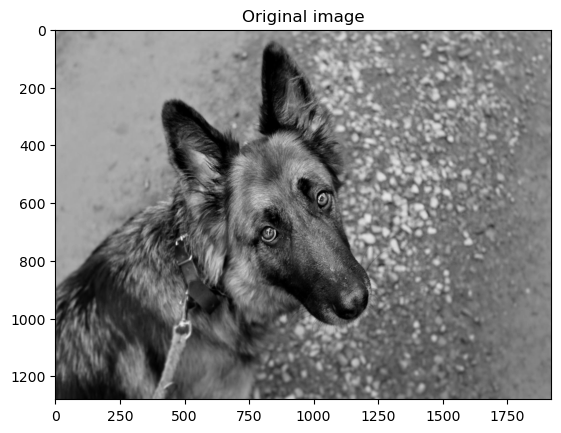

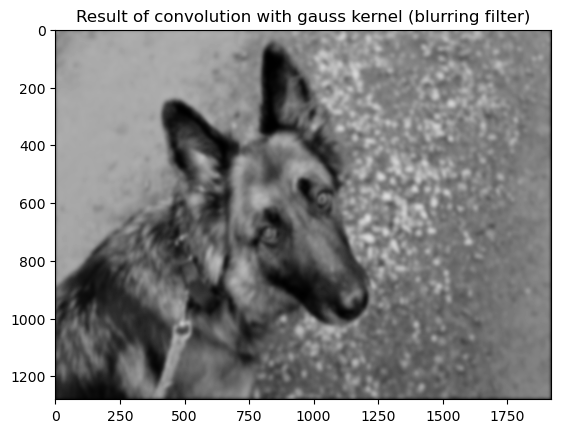

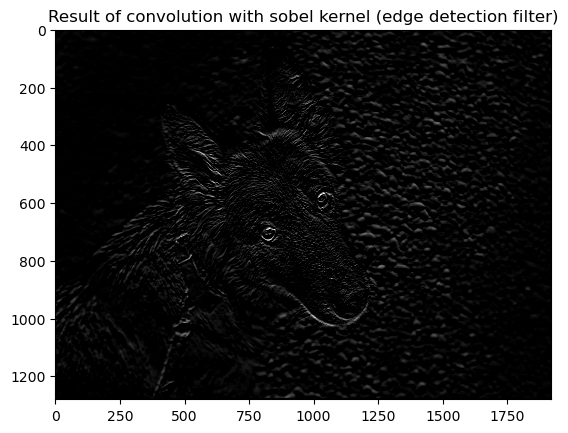

In [10]:
%matplotlib inline

# Now an example using a real image and first a gaussian low-pass filter and then a sobel filter
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import time

def generate_gauss_mask(sigma, K=1):
    side = np.ceil(1 + 8 * sigma)
    y, x = np.mgrid[-side // 2 + 1 : (side // 2) + 1, -side // 2 + 1 : (side // 2) + 1]
    ker_coef = K / (2 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2)))

    return g, ker_coef


img_path = "data/IMG-2167.JPG"
image_of_cute_dog = imageio.imread(img_path, mode='L')

plt.imshow(image_of_cute_dog, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.title("Original image")
plt.show()

gauss, kernel = generate_gauss_mask(sigma=6)
gauss_kernel = gauss*kernel

filtered_image = convolve(image_of_cute_dog, gauss_kernel)
plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.title("Result of convolution with gauss kernel (blurring filter)")
plt.show()

sobel_kernel = np.array([[1, 2, 1],
                    [0, 0, 0], 
                    [-1, -2, -1]])

filtered_image = convolve(image_of_cute_dog, sobel_kernel)

plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.title("Result of convolution with sobel kernel (edge detection filter)")
plt.show()

### Layers

The code below initialises global variables for readability and
describes the abstract class Layers. This is not important in order to
understand the CNN, but is benefitial for organizing the code neatly.

In [11]:
import math
import autograd.numpy as np
from copy import deepcopy, copy
from autograd import grad
from typing import Callable

# global variables for index readability
input_index = 0
node_index = 1
bias_index = 1
input_channel_index = 1
feature_maps_index = 1
height_index = 2
width_index = 3
kernel_feature_maps_index = 1
kernel_input_channels_index = 0


class Layer:
    def __init__(self, seed):
        self.seed = seed

    def _feedforward(self):
        raise NotImplementedError

    def _backpropagate(self):
        raise NotImplementedError

    def _reset_weights(self, previous_nodes):
        raise NotImplementedError

### Convolution2DLayer: convolution in a hidden layer

After establishing the foundational understanding of applying
convolution to spatial data, let us delve into the intricate workings
of a convolutional layer in a Convolutional Neural Network (CNN). The
primary function of convolution, as previously discussed, is to
extract pertinent information from images while simultaneously
decreasing the scale of our data. To initiate the image processing, we
shall begin by partitioning the images into color channels (unless the
image is grayscale), comprising three primary colors: red, green, and
blue. We will subsequently utilize trainable kernels to construct a
higher-dimensional encoding of each channel called feature
maps. Successive layers will receive these feature maps as inputs,
generating further encodings, albeit with reduced dimensions. The term
trainable kernels denotes the initialization of pre-defined
kernel-shaped weights, which we will then train via backpropagation,
similar to how weights are trained in a Feedforward Neural Network.

To ensure seamless integration between our implementation of the
convolutional layer and popular machine learning frameworks like
Tensorflow (Keras) and PyTorch, we have adopted a design pattern that
mirrors the construction of models using these APIs. This involves
implementing our convolutional layer as a Python class or object,
which allows for a more modular and flexible approach to building
neural networks. By structuring our code in this way, users can easily
incorporate our implementation into their existing machine learning
pipelines without having to make significant changes to their
codebase. Additionally, this design pattern promotes code reusability
and makes it easier to maintain and update our convolutional layer
implementation over time.

Note that the Convolution2DLayer takes in an activation function as a parameter, as it also performs non-linearity.

In [12]:
class Convolution2DLayer(Layer):
    def __init__(
        self,
        input_channels,
        feature_maps,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pad,
        act_func: Callable,
        seed=None,
        reset_weights_independently=True,
    ):
        super().__init__(seed)
        self.input_channels = input_channels
        self.feature_maps = feature_maps
        self.kernel_height = kernel_height
        self.kernel_width = kernel_width
        self.v_stride = v_stride
        self.h_stride = h_stride
        self.pad = pad
        self.act_func = act_func

        # such that the layer can be used on its own
        # outside of the CNN module
        if reset_weights_independently == True:
            self._reset_weights_independently()

    def _feedforward(self, X_batch):
        # note that the shape of X_batch = [inputs, input_maps, img_height, img_width]

        # pad the input batch
        X_batch_padded = self._padding(X_batch)

        # calculate height_index and width_index after stride
        strided_height = int(np.ceil(X_batch.shape[height_index] / self.v_stride))
        strided_width = int(np.ceil(X_batch.shape[width_index] / self.h_stride))

        # create output array
        output = np.ndarray(
            (
                X_batch.shape[input_index],
                self.feature_maps,
                strided_height,
                strided_width,
            )
        )

        # save input and output for backpropagation
        self.X_batch_feedforward = X_batch
        self.output_shape = output.shape

        # checking for errors, no need to look here :)
        self._check_for_errors()

        # convolve input with kernel
        for img in range(X_batch.shape[input_index]):
            for chin in range(self.input_channels):
                for fmap in range(self.feature_maps):
                    out_h = 0
                    for h in range(0, X_batch.shape[height_index], self.v_stride):
                        out_w = 0
                        for w in range(0, X_batch.shape[width_index], self.h_stride):
                            output[img, fmap, out_h, out_w] = np.sum(
                                X_batch_padded[
                                    img,
                                    chin,
                                    h : h + self.kernel_height,
                                    w : w + self.kernel_width,
                                ]
                                * self.kernel[chin, fmap, :, :]
                            )
                            out_w += 1
                        out_h += 1

        # Pay attention to the fact that we're not rotating the kernel by 180 degrees when filtering the image in
        # the convolutional layer, as convolution in terms of Machine Learning is a procedure known as cross-correlation
        # in image processing and signal processing

        # return a
        return self.act_func(output / (self.kernel_height))

    def _backpropagate(self, delta_term_next):
        # intiate matrices
        delta_term = np.zeros((self.X_batch_feedforward.shape))
        gradient_kernel = np.zeros((self.kernel.shape))

        # pad input for convolution
        X_batch_padded = self._padding(self.X_batch_feedforward)

        # Since an activation function is used at the output of the convolution layer, its derivative
        # has to be accounted for in the backpropagation -> as if ReLU was a layer on its own.
        act_derivative = derivate(self.act_func)
        delta_term_next = act_derivative(delta_term_next)

        # fill in 0's for values removed by vertical stride in feedforward
        if self.v_stride > 1:
            v_ind = 1
            for i in range(delta_term_next.shape[height_index]):
                for j in range(self.v_stride - 1):
                    delta_term_next = np.insert(
                        delta_term_next, v_ind, 0, axis=height_index
                    )
                v_ind += self.v_stride

        # fill in 0's for values removed by horizontal stride in feedforward
        if self.h_stride > 1:
            h_ind = 1
            for i in range(delta_term_next.shape[width_index]):
                for k in range(self.h_stride - 1):
                    delta_term_next = np.insert(
                        delta_term_next, h_ind, 0, axis=width_index
                    )
                h_ind += self.h_stride

        # crops out 0-rows and 0-columns
        delta_term_next = delta_term_next[
            :,
            :,
            : self.X_batch_feedforward.shape[height_index],
            : self.X_batch_feedforward.shape[width_index],
        ]

        # the gradient received from the next layer also needs to be padded
        delta_term_next = self._padding(delta_term_next)

        # calculate delta term by convolving next delta term with kernel
        for img in range(self.X_batch_feedforward.shape[input_index]):
            for chin in range(self.input_channels):
                for fmap in range(self.feature_maps):
                    for h in range(self.X_batch_feedforward.shape[height_index]):
                        for w in range(self.X_batch_feedforward.shape[width_index]):
                            delta_term[img, chin, h, w] = np.sum(
                                delta_term_next[
                                    img,
                                    fmap,
                                    h : h + self.kernel_height,
                                    w : w + self.kernel_width,
                                ]
                                * np.rot90(np.rot90(self.kernel[chin, fmap, :, :]))
                            )

        # calculate gradient for kernel for weight update
        # also via convolution
        for chin in range(self.input_channels):
            for fmap in range(self.feature_maps):
                for k_x in range(self.kernel_height):
                    for k_y in range(self.kernel_width):
                        gradient_kernel[chin, fmap, k_x, k_y] = np.sum(
                            X_batch_padded[
                                img,
                                chin,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ]
                            * delta_term_next[
                                img,
                                fmap,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ]
                        )
        # all kernels are updated with weight gradient of kernel
        self.kernel -= gradient_kernel

        # return delta term
        return delta_term

    def _padding(self, X_batch, batch_type="image"):

        # same padding for images
        if self.pad == "same" and batch_type == "image":
            padded_height = X_batch.shape[height_index] + (self.kernel_height // 2) * 2
            padded_width = X_batch.shape[width_index] + (self.kernel_width // 2) * 2
            half_kernel_height = self.kernel_height // 2
            half_kernel_width = self.kernel_width // 2

            # initialize padded array
            X_batch_padded = np.ndarray(
                (
                    X_batch.shape[input_index],
                    X_batch.shape[feature_maps_index],
                    padded_height,
                    padded_width,
                )
            )

            # zero pad all images in X_batch
            for img in range(X_batch.shape[input_index]):
                padded_img = np.zeros(
                    (X_batch.shape[feature_maps_index], padded_height, padded_width)
                )
                padded_img[
                    :,
                    half_kernel_height : padded_height - half_kernel_height,
                    half_kernel_width : padded_width - half_kernel_width,
                ] = X_batch[img, :, :, :]
                X_batch_padded[img, :, :, :] = padded_img[:, :, :]

            return X_batch_padded

        # same padding for gradients
        elif self.pad == "same" and batch_type == "grad":
            padded_height = X_batch.shape[height_index] + (self.kernel_height // 2) * 2
            padded_width = X_batch.shape[width_index] + (self.kernel_width // 2) * 2
            half_kernel_height = self.kernel_height // 2
            half_kernel_width = self.kernel_width // 2

            # initialize padded array
            delta_term_padded = np.zeros(
                (
                    X_batch.shape[input_index],
                    X_batch.shape[feature_maps_index],
                    padded_height,
                    padded_width,
                )
            )

            # zero pad delta term
            delta_term_padded[
                :, :, : X_batch.shape[height_index], : X_batch.shape[width_index]
            ] = X_batch[:, :, :, :]

            return delta_term_padded

        else:
            return X_batch

    def _reset_weights_independently(self):
        # sets seed to remove randomness inbetween runs
        if self.seed is not None:
            np.random.seed(self.seed)

        # initializes kernel matrix
        self.kernel = np.ndarray(
            (
                self.input_channels,
                self.feature_maps,
                self.kernel_height,
                self.kernel_width,
            )
        )

        # randomly initializes weights
        for chin in range(self.kernel.shape[kernel_input_channels_index]):
            for fmap in range(self.kernel.shape[kernel_feature_maps_index]):
                self.kernel[chin, fmap, :, :] = np.random.rand(
                    self.kernel_height, self.kernel_width
                )

    def _reset_weights(self, previous_nodes):
        # sets weights
        self._reset_weights_independently()

        # returns shape of output used for subsequent layer's weight initiation
        strided_height = int(
            np.ceil(previous_nodes.shape[height_index] / self.v_stride)
        )
        strided_width = int(np.ceil(previous_nodes.shape[width_index] / self.h_stride))
        next_nodes = np.ones(
            (
                previous_nodes.shape[input_index],
                self.feature_maps,
                strided_height,
                strided_width,
            )
        )
        return next_nodes / self.kernel_height

    def _check_for_errors(self):
        if self.X_batch_feedforward.shape[input_channel_index] != self.input_channels:
            raise AssertionError(
                f"ERROR: Number of input channels in data ({self.X_batch_feedforward.shape[input_channel_index]}) is not equal to input channels in Convolution2DLayerOPT ({self.input_channels})! Please change the number of input channels of the Convolution2DLayer such that they are equal"
            )

### Backpropagation in the convolutional layer

As you may have noticed, we have not yet explained how the
backpropagation algorithm works in a convolutional layer. However,
having covered all other major details about convolutional layers, we
are now prepared to do so. It should come as no surprise that the
calculation of delta terms at each convolutional layer takes the form
of convolution. After the gradient has been propagated backwards
through the flattening layer, where it was reshaped into an
appropriate form, calculating the update value for the kernel is
simply a matter of convolving the output gradient with the input of
the layer for which we are updating the weights. For more detail, this
article serves as an excellent resource, see
<https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c>

### Demonstration

We can use the convolutional layer above to perform a simple convolution on an image of the now familiar cute dog.

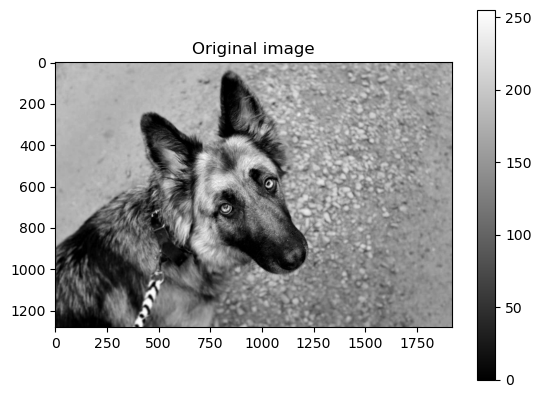

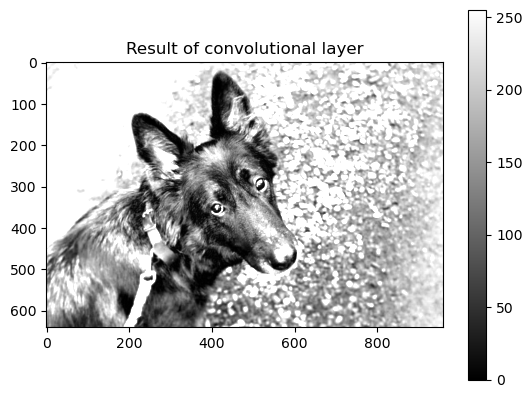

In [13]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

def plot_convolution_result(X, layer):
    plt.imshow(X[0, 0, :, :], vmin=0, vmax=255, cmap="gray")
    plt.title("Original image")
    plt.colorbar()
    plt.show()
    conv_result = layer._feedforward(X)
    plt.title("Result of convolutional layer")
    plt.imshow(conv_result[0, 0, :, :], vmin=0, vmax=255, cmap="gray")
    plt.colorbar()
    plt.show()

# create layer
layer = Convolution2DLayer(
    input_channels=3,
    feature_maps=1,
    kernel_height=4,
    kernel_width=4,
    v_stride=2,
    h_stride=2,
    pad="same",
    act_func=identity,
    seed=2023,
    )

# read in image path, make data correct format
img_path = img_path = "data/IMG-2167.JPG"
image_of_cute_dog = imageio.imread(img_path)
image_shape = image_of_cute_dog.shape
image_of_cute_dog = image_of_cute_dog.reshape(1, image_shape[0], image_shape[1], image_shape[2])
image_of_cute_dog = image_of_cute_dog.transpose(0, 3, 1, 2)

# plot the result of the convolution
plot_convolution_result(image_of_cute_dog, layer)

We cobserve that the result has half the pixels on each axis due to
the fact that we've used a horizontal and vertical stride of 2. The
result of this convolution is not very insightfull, as the kernel has
completely random values for the first feedforward pass. However, as
we perform multiple forward and backward passes, the results of the
convolution should provide identifying features of the image it uses
for classification.

Note that image data usually comes in many different shapes and sizes,
but for our CNN we require the input data be formatted as \[Number of
inputs, input channels, input height, input width\]. Occasionally, the
data you come accross use will be formatted like this, but on many
occasions reshaping and transposing the dimensions is sadly necessary.

### Pooling Layer

The pooling layer is another widely used type of layer in
convolutional neural networks that enables data downsampling to a more
manageable size. Despite recent technological advancements that allow
for convolution without excessive size reduction of the data, the
pooling layer still remains a fundamental component of convolutional
neural networks. It can be used before, after, or in between
convolutional layers, although finding the optimal placement of layers
and network depth requires experimentation to achieve the best
performance for a given problem. The code we provide allows you to
perform two types of pooling known as max pooling and average pooling.

In [14]:
class Pooling2DLayer(Layer):
    def __init__(
        self,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pooling="max",
        seed=None,
    ):
        super().__init__(seed)
        self.kernel_height = kernel_height
        self.kernel_width = kernel_width
        self.v_stride = v_stride
        self.h_stride = h_stride
        self.pooling = pooling

    def _feedforward(self, X_batch):
        # Saving the input for use in the backwardpass
        self.X_batch_feedforward = X_batch

        # check if user is silly
        self._check_for_errors()

        # Computing the size of the feature maps based on kernel size and the stride parameter
        strided_height = (
            X_batch.shape[height_index] - self.kernel_height
        ) // self.v_stride + 1
        if X_batch.shape[height_index] == X_batch.shape[width_index]:
            strided_width = strided_height
        else:
            strided_width = (
                X_batch.shape[width_index] - self.kernel_width
            ) // self.h_stride + 1

        # initialize output array
        output = np.ndarray(
            (
                X_batch.shape[input_index],
                X_batch.shape[feature_maps_index],
                strided_height,
                strided_width,
            )
        )

        # select pooling action, either max or average pooling
        if self.pooling == "max":
            self.pooling_action = np.max
        elif self.pooling == "average":
            self.pooling_action = np.mean

        # pool based on kernel size and stride
        for img in range(output.shape[input_index]):
            for fmap in range(output.shape[feature_maps_index]):
                for h in range(strided_height):
                    for w in range(strided_width):
                        output[img, fmap, h, w] = self.pooling_action(
                            X_batch[
                                img,
                                fmap,
                                (h * self.v_stride) : (h * self.v_stride)
                                + self.kernel_height,
                                (w * self.h_stride) : (w * self.h_stride)
                                + self.kernel_width,
                            ]
                        )

        # output for feedforward in next layer
        return output

    def _backpropagate(self, delta_term_next):
        # initiate delta term array
        delta_term = np.zeros((self.X_batch_feedforward.shape))

        for img in range(delta_term_next.shape[input_index]):
            for fmap in range(delta_term_next.shape[feature_maps_index]):
                for h in range(0, delta_term_next.shape[height_index], self.v_stride):
                    for w in range(
                        0, delta_term_next.shape[width_index], self.h_stride
                    ):
                        # max pooling
                        if self.pooling == "max":
                            # get window
                            window = self.X_batch_feedforward[
                                img,
                                fmap,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ]

                            # find max values indices in window
                            max_h, max_w = np.unravel_index(
                                window.argmax(), window.shape
                            )

                            # set values in new, upsampled delta term
                            delta_term[
                                img,
                                fmap,
                                (h + max_h),
                                (w + max_w),
                            ] += delta_term_next[img, fmap, h, w]

                        # average pooling
                        if self.pooling == "average":
                            delta_term[
                                img,
                                fmap,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ] = (
                                delta_term_next[img, fmap, h, w]
                                / self.kernel_height
                                / self.kernel_width
                            )
        # returns input to backpropagation in previous layer
        return delta_term

    def _reset_weights(self, previous_nodes):
        # calculate strided height, strided width
        strided_height = (
            previous_nodes.shape[height_index] - self.kernel_height
        ) // self.v_stride + 1
        if previous_nodes.shape[height_index] == previous_nodes.shape[width_index]:
            strided_width = strided_height
        else:
            strided_width = (
                previous_nodes.shape[width_index] - self.kernel_width
            ) // self.h_stride + 1

        # initiate output array
        output = np.ones(
            (
                previous_nodes.shape[input_index],
                previous_nodes.shape[feature_maps_index],
                strided_height,
                strided_width,
            )
        )

        # returns output with shape used for reset weights in next layer
        return output

    def _check_for_errors(self):
        # check if input is smaller than kernel size -> error
        assert (
            self.X_batch_feedforward.shape[width_index] >= self.kernel_width
        ), f"ERROR: Pooling kernel width_index ({self.kernel_width}) larger than data width_index ({self.X_batch_feedforward.input.shape[2]}), please lower the kernel width_index of the Pooling2DLayer"
        assert (
            self.X_batch_feedforward.shape[height_index] >= self.kernel_height
        ), f"ERROR: Pooling kernel height_index ({self.kernel_height}) larger than data height_index ({self.X_batch_feedforward.input.shape[3]}), please lower the kernel height_index of the Pooling2DLayer"

### Flattening Layer

Before we can begin building our first CNN model, we need to introduce
the flattening layer. As its name suggests, the flattening layer
transforms the data into a one-dimensional vector that can be fed into
the feedforward layers of our network. This layer plays a crucial role
in preparing the data for further processing in the
network. Additionally, the flattening layer is responsible for
reshaping the gradient to the proper shape during
backpropagation. This ensures that the kernels are correctly updated,
allowing for effective learning in the network.

In [15]:
class FlattenLayer(Layer):
    def __init__(self, act_func=LRELU, seed=None):
        super().__init__(seed)
        self.act_func = act_func

    def _feedforward(self, X_batch):
        # save input for backpropagation
        self.X_batch_feedforward_shape = X_batch.shape
        # Remember, the data has the following shape: (I, FM, H, W, ) in the convolutional layers
        # whilst the data has the shape (I, FM * H * W) in the fully connected layers
        # I = Inputs, FM = Feature Maps, H = Height and W = Width.
        X_batch = X_batch.reshape(
            X_batch.shape[input_index],
            X_batch.shape[feature_maps_index]
            * X_batch.shape[height_index]
            * X_batch.shape[width_index],
        )

        # add bias to a
        self.z_matrix = X_batch
        bias = np.ones((X_batch.shape[input_index], 1)) * 0.01
        self.a_matrix = np.hstack([bias, X_batch])

        # return a, the input to feedforward in next layer
        return self.a_matrix

    def _backpropagate(self, weights_next, delta_term_next):
        activation_derivative = derivate(self.act_func)

        # calculate delta term
        delta_term = (
            weights_next[bias_index:, :] @ delta_term_next.T
        ).T * activation_derivative(self.z_matrix)

        # FlattenLayer does not update weights
        # reshapes delta layer to convolutional layer data format [Input, Feature_Maps, Height, Width]
        return delta_term.reshape(self.X_batch_feedforward_shape)

    def _reset_weights(self, previous_nodes):
        # note that the previous nodes to the FlattenLayer are from the convolutional layers
        previous_nodes = previous_nodes.reshape(
            previous_nodes.shape[input_index],
            previous_nodes.shape[feature_maps_index]
            * previous_nodes.shape[height_index]
            * previous_nodes.shape[width_index],
        )

        # return shape used in reset_weights in next layer
        return previous_nodes.shape[node_index]

    def get_prev_a(self):
        return self.a_matrix

### Fully Connected Layers

Finally, the result from the flatten layer will pass to a series of
fully connected layers, which function as a normal feed forward neural
network. The fully connected layers are split into two classes;
FullyConnectedLayer which acts as a hidden layer, and OutputLayer,
which acts as the single output layer at the end of the CNN. If one
wishes to use this codebase to construct a normal feed forward neural
network, it must start with a FlattenLayer due to techincal details
regarding weight intitialization. However many FullyConnectedLayers
can be added to the CNN, and in each layer the amount of nodes, which
activation function and scheduler to use can be specified. In
practice, the scheduler will be specified in the CNN object
initialization, and inherited if no other scheduler is specified.

In [16]:
class FullyConnectedLayer(Layer):
    # FullyConnectedLayer per default uses LRELU and Adam scheduler
    # with an eta of 0.0001, rho of 0.9 and rho2 of 0.999
    def __init__(
        self,
        nodes: int,
        act_func: Callable = LRELU,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        super().__init__(seed)
        self.nodes = nodes
        self.act_func = act_func
        self.scheduler_weight = copy(scheduler)
        self.scheduler_bias = copy(scheduler)

        # initiate matrices for later
        self.weights = None
        self.a_matrix = None
        self.z_matrix = None

    def _feedforward(self, X_batch):
        # calculate z
        self.z_matrix = X_batch @ self.weights

        # calculate a, add bias
        bias = np.ones((X_batch.shape[input_index], 1)) * 0.01
        self.a_matrix = self.act_func(self.z_matrix)
        self.a_matrix = np.hstack([bias, self.a_matrix])

        # return a, the input for feedforward in next layer
        return self.a_matrix

    def _backpropagate(self, weights_next, delta_term_next, a_previous, lam):
        # take the derivative of the activation function
        activation_derivative = derivate(self.act_func)

        # calculate the delta term
        delta_term = (
            weights_next[bias_index:, :] @ delta_term_next.T
        ).T * activation_derivative(self.z_matrix)

        # intitiate matrix to store gradient
        # note that we exclude the bias term, which we will calculate later
        gradient_weights = np.zeros(
            (
                a_previous.shape[input_index],
                a_previous.shape[node_index] - bias_index,
                delta_term.shape[node_index],
            )
        )

        # calculate gradient = delta term * previous a
        for i in range(len(delta_term)):
            gradient_weights[i, :, :] = np.outer(
                a_previous[i, bias_index:], delta_term[i, :]
            )

        # sum the gradient, divide by input_index
        gradient_weights = np.mean(gradient_weights, axis=input_index)
        # for the bias gradient we do not multiply by previous a
        gradient_bias = np.mean(delta_term, axis=input_index).reshape(
            1, delta_term.shape[node_index]
        )

        # regularization term
        gradient_weights += self.weights[bias_index:, :] * lam

        # send gradients into scheduler
        # returns update matrix which will be used to update the weights and bias
        update_matrix = np.vstack(
            [
                self.scheduler_bias.update_change(gradient_bias),
                self.scheduler_weight.update_change(gradient_weights),
            ]
        )

        # update weights
        self.weights -= update_matrix

        # return weights and delta term, input for backpropagation in previous layer
        return self.weights, delta_term

    def _reset_weights(self, previous_nodes):
        # sets seed to remove randomness inbetween runs
        if self.seed is not None:
            np.random.seed(self.seed)

        # add bias, initiate random weights
        bias = 1
        self.weights = np.random.randn(previous_nodes + bias, self.nodes)

        # returns number of nodes, used for reset_weights in next layer
        return self.nodes

    def _reset_scheduler(self):
        # resets scheduler per epoch
        self.scheduler_weight.reset()
        self.scheduler_bias.reset()

    def get_prev_a(self):
        # returns a matrix, used in backpropagation
        return self.a_matrix


class OutputLayer(FullyConnectedLayer):
    def __init__(
        self,
        nodes: int,
        output_func: Callable = LRELU,
        cost_func: Callable = CostCrossEntropy,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        super().__init__(nodes, output_func, copy(scheduler), seed)
        self.cost_func = cost_func

        # initiate matrices for later
        self.weights = None
        self.a_matrix = None
        self.z_matrix = None

        # decides if the output layer performs binary or multi-class classification
        self._set_pred_format()

    def _feedforward(self, X_batch: np.ndarray):
        # calculate a, z
        # note that bias is not added as this would create an extra output class
        self.z_matrix = X_batch @ self.weights
        self.a_matrix = self.act_func(self.z_matrix)

        # returns prediction
        return self.a_matrix

    def _backpropagate(self, target, a_previous, lam):
        # note that in the OutputLayer the activation function is the output function
        activation_derivative = derivate(self.act_func)

        # calculate output delta terms
        # for multi-class or binary classification
        if self.pred_format == "Multi-class":
            delta_term = self.a_matrix - target
        else:
            cost_func_derivative = grad(self.cost_func(target))
            delta_term = activation_derivative(self.z_matrix) * cost_func_derivative(
                self.a_matrix
            )

        # intiate matrix that stores gradient
        gradient_weights = np.zeros(
            (
                a_previous.shape[input_index],
                a_previous.shape[node_index] - bias_index,
                delta_term.shape[node_index],
            )
        )

        # calculate gradient = delta term * previous a
        for i in range(len(delta_term)):
            gradient_weights[i, :, :] = np.outer(
                a_previous[i, bias_index:], delta_term[i, :]
            )

        # sum the gradient, divide by input_index
        gradient_weights = np.mean(gradient_weights, axis=input_index)
        # for the bias gradient we do not multiply by previous a
        gradient_bias = np.mean(delta_term, axis=input_index).reshape(
            1, delta_term.shape[node_index]
        )

        # regularization term
        gradient_weights += self.weights[bias_index:, :] * lam

        # send gradients into scheduler
        # returns update matrix which will be used to update the weights and bias
        update_matrix = np.vstack(
            [
                self.scheduler_bias.update_change(gradient_bias),
                self.scheduler_weight.update_change(gradient_weights),
            ]
        )

        # update weights
        self.weights -= update_matrix

        # return weights and delta term, input for backpropagation in previous layer
        return self.weights, delta_term

    def _reset_weights(self, previous_nodes):
        # sets seed to remove randomness inbetween runs
        if self.seed is not None:
            np.random.seed(self.seed)

        # add bias, initiate random weights
        bias = 1
        self.weights = np.random.rand(previous_nodes + bias, self.nodes)

        # returns number of nodes, used for reset_weights in next layer
        return self.nodes

    def _reset_scheduler(self):
        # resets scheduler per epoch
        self.scheduler_weight.reset()
        self.scheduler_bias.reset()

    def _set_pred_format(self):
        # sets prediction format to either regression, binary or multi-class classification
        if self.act_func.__name__ is None or self.act_func.__name__ == "identity":
            self.pred_format = "Regression"
        elif self.act_func.__name__ == "sigmoid" or self.act_func.__name__ == "tanh":
            self.pred_format = "Binary"
        else:
            self.pred_format = "Multi-class"

    def get_pred_format(self):
        # returns format of prediction
        return self.pred_format

### Optimized Convolution2DLayer

For our CNN, we have also implemented an optimized version of the
Convolution2DLayer, Convolution2DLayerOPT, which runs much faster. See
VII. Remarks for discussion. This layer will per default be used by
the CNN due to its computational advantages, but is much less
readable. We've documented it such that specially interested students
can understand the principles behind it, but it is not recommended to
read. In short, we reshape and transpose parts of the image such that
the convolutional operation can be swapped out for a simple matrix
multiplication.

In [17]:
class Convolution2DLayerOPT(Convolution2DLayer):
    """
    Am optimized version of the convolution layer above which
    utilizes an approach of extracting windows of size equivalent
    in size to the filter. The convoution is then performed on those
    windows instead of a full feature map.
    """

    def __init__(
        self,
        input_channels,
        feature_maps,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pad,
        act_func: Callable,
        seed=None,
        reset_weights_independently=True,
    ):
        super().__init__(
            input_channels,
            feature_maps,
            kernel_height,
            kernel_width,
            v_stride,
            h_stride,
            pad,
            act_func,
            seed,
        )
        # true if layer is used outside of CNN
        if reset_weights_independently == True:
            self._reset_weights_independently()

    def _feedforward(self, X_batch):
        # The optimized _feedforward method is difficult to understand but computationally more efficient
        # for a more "by the book" approach, please look at the _feedforward method of Convolution2DLayer

        # save the input for backpropagation
        self.X_batch_feedforward = X_batch

        # check that there are the correct amount of input channels
        self._check_for_errors()

        # calculate new shape after stride
        strided_height = int(np.ceil(X_batch.shape[height_index] / self.v_stride))
        strided_width = int(np.ceil(X_batch.shape[width_index] / self.h_stride))

        # get windows of the image for more computationally efficient convolution
        # the idea is that we want to align the dimensions that we wish to matrix
        # multiply, then use a simple matrix multiplication instead of convolution.
        # then, we reshape the size back to its intended shape
        windows = self._extract_windows(X_batch)
        windows = windows.transpose(1, 0, 2, 3, 4).reshape(
            X_batch.shape[input_index],
            strided_height * strided_width,
            -1,
        )

        # reshape the kernel for more computationally efficient convolution
        kernel = self.kernel
        kernel = kernel.transpose(0, 2, 3, 1).reshape(
            kernel.shape[kernel_input_channels_index]
            * kernel.shape[height_index]
            * kernel.shape[width_index],
            -1,
        )

        # use simple matrix calculation to obtain output
        output = (
            (windows @ kernel)
            .reshape(
                X_batch.shape[input_index],
                strided_height,
                strided_width,
                -1,
            )
            .transpose(0, 3, 1, 2)
        )

        # The output is reshaped and rearranged to appropriate shape
        return self.act_func(
            output / (self.kernel_height * X_batch.shape[feature_maps_index])
        )

    def _backpropagate(self, delta_term_next):
        # The optimized _backpropagate method is difficult to understand but computationally more efficient
        # for a more "by the book" approach, please look at the _backpropagate method of Convolution2DLayer
        act_derivative = derivate(self.act_func)
        delta_term_next = act_derivative(delta_term_next)

        # calculate strided dimensions
        strided_height = int(
            np.ceil(self.X_batch_feedforward.shape[height_index] / self.v_stride)
        )
        strided_width = int(
            np.ceil(self.X_batch_feedforward.shape[width_index] / self.h_stride)
        )

        # copy kernel
        kernel = self.kernel

        # get windows, reshape for matrix multiplication
        windows = self._extract_windows(self.X_batch_feedforward, "image").reshape(
            self.X_batch_feedforward.shape[input_index]
            * strided_height
            * strided_width,
            -1,
        )

        # initialize output gradient, reshape and transpose into correct shape
        # for matrix multiplication
        output_grad_tr = delta_term_next.transpose(0, 2, 3, 1).reshape(
            self.X_batch_feedforward.shape[input_index]
            * strided_height
            * strided_width,
            -1,
        )

        # calculate gradient kernel via simple matrix multiplication and reshaping
        gradient_kernel = (
            (windows.T @ output_grad_tr)
            .reshape(
                kernel.shape[kernel_input_channels_index],
                kernel.shape[height_index],
                kernel.shape[width_index],
                kernel.shape[kernel_feature_maps_index],
            )
            .transpose(0, 3, 1, 2)
        )

        # for computing the input gradient
        windows_out, upsampled_height, upsampled_width = self._extract_windows(
            delta_term_next, "grad"
        )

        # calculate new window dimensions
        new_windows_first_dim = (
            self.X_batch_feedforward.shape[input_index]
            * upsampled_height
            * upsampled_width
        )
        # ceil allows for various asymmetric kernels
        new_windows_sec_dim = int(np.ceil(windows_out.size / new_windows_first_dim))

        # reshape for matrix multiplication
        windows_out = windows_out.transpose(1, 0, 2, 3, 4).reshape(
            new_windows_first_dim, new_windows_sec_dim
        )

        # reshape for matrix multiplication
        kernel_reshaped = kernel.reshape(self.input_channels, -1)

        # calculating input gradient for next convolutional layer
        input_grad = (windows_out @ kernel_reshaped.T).reshape(
            self.X_batch_feedforward.shape[input_index],
            upsampled_height,
            upsampled_width,
            kernel.shape[kernel_input_channels_index],
        )
        input_grad = input_grad.transpose(0, 3, 1, 2)

        # Update the weights in the kernel
        self.kernel -= gradient_kernel

        # Output the gradient to propagate backwards
        return input_grad

    def _extract_windows(self, X_batch, batch_type="image"):
        """
        Receives as input the X_batch with shape (inputs, feature_maps, image_height, image_width)
        and extract windows of size kernel_height * kernel_width for every image and every feature_map.
        It then returns an np.ndarray of shape (image_height * image_width, inputs, feature_maps, kernel_height, kernel_width)
        which will be used either to filter the images in feedforward or to calculate the gradient.
        """

        # initialize list of windows
        windows = []

        if batch_type == "image":
            # pad the images
            X_batch_padded = self._padding(X_batch, batch_type="image")
            img_height, img_width = X_batch_padded.shape[2:]
            # For each location in the image...
            for h in range(
                0,
                X_batch.shape[height_index],
                self.v_stride,
            ):
                for w in range(
                    0,
                    X_batch.shape[width_index],
                    self.h_stride,
                ):
                    # ...obtain an image patch of the original size (strided)

                    # get window
                    window = X_batch_padded[
                        :,
                        :,
                        h : h + self.kernel_height,
                        w : w + self.kernel_width,
                    ]

                    # append to list of windows
                    windows.append(window)

            # return numpy array instead of list
            return np.stack(windows)

        # In order to be able to perform backprogagation by the method of window extraction,
        # here is a modified approach to extracting the windows which allow for the necessary
        # upsampling of the gradient in case the on of the stride parameters is larger than one.

        if batch_type == "grad":

            # In the case of one of the stride parameters being odd, we have to take some
            # extra care in calculating the upsampled size of X_batch. We solve this
            # by simply flooring the result of dividing stride by 2.
            if self.v_stride < 2 or self.v_stride % 2 == 0:
                v_stride = 0
            else:
                v_stride = int(np.floor(self.v_stride / 2))

            if self.h_stride < 2 or self.h_stride % 2 == 0:
                h_stride = 0
            else:
                h_stride = int(np.floor(self.h_stride / 2))

            upsampled_height = (X_batch.shape[height_index] * self.v_stride) - v_stride
            upsampled_width = (X_batch.shape[width_index] * self.h_stride) - h_stride

            # When upsampling, we need to insert rows and columns filled with zeros
            # into each feature map. How many of those we have to insert is purely
            # dependant on the value of stride parameter in the vertical and horizontal
            # direction.
            if self.v_stride > 1:
                v_ind = 1
                for i in range(X_batch.shape[height_index]):
                    for j in range(self.v_stride - 1):
                        X_batch = np.insert(X_batch, v_ind, 0, axis=height_index)
                    v_ind += self.v_stride

            if self.h_stride > 1:
                h_ind = 1
                for i in range(X_batch.shape[width_index]):
                    for k in range(self.h_stride - 1):
                        X_batch = np.insert(X_batch, h_ind, 0, axis=width_index)
                    h_ind += self.h_stride

            # Since the insertion of zero-filled rows and columns isn't perfect, we have
            # to assure that the resulting feature maps will have the expected upsampled height
            # and width by cutting them og at desired dimensions.

            X_batch = X_batch[:, :, :upsampled_height, :upsampled_width]

            X_batch_padded = self._padding(X_batch, batch_type="grad")

            # initialize list of windows
            windows = []

            # For each location in the image...
            for h in range(
                0,
                X_batch.shape[height_index],
                self.v_stride,
            ):
                for w in range(
                    0,
                    X_batch.shape[width_index],
                    self.h_stride,
                ):
                    # ...obtain an image patch of the original size (strided)

                    # get window
                    window = X_batch_padded[
                        :, :, h : h + self.kernel_height, w : w + self.kernel_width
                    ]

                    # append window to list
                    windows.append(window)

            # return numpy array, unsampled dimensions
            return np.stack(windows), upsampled_height, upsampled_width

    def _check_for_errors(self):
        # compares input channels of data to input channels of Convolution2DLayer
        if self.X_batch_feedforward.shape[input_channel_index] != self.input_channels:
            raise AssertionError(
                f"ERROR: Number of input channels in data ({self.X_batch_feedforward.shape[input_channel_index]}) is not equal to input channels in Convolution2DLayerOPT ({self.input_channels})! Please change the number of input channels of the Convolution2DLayer such that they are equal"
            )

### The Convolutional Neural Network (CNN)

Finally, we present the code for the CNN. The CNN class organizes all the layers, and allows for training on image data.

In [18]:
import math
import autograd.numpy as np
import sys
import warnings
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy
from typing import Tuple, Callable
from sklearn.utils import resample

warnings.simplefilter("error")


class CNN:
    def __init__(
        self,
        cost_func: Callable = CostCrossEntropy,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        """
        Description:
        ------------
            Instantiates CNN object

        Parameters:
        ------------
            I   output_func (costFunctions) cost function for feed forward neural network part of CNN,
                such as "CostLogReg", "CostOLS" or "CostCrossEntropy"

            II  scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant. Note that schedulers have
                to be instantiated first with proper parameters (for example eta, rho and rho2 for Adam)

            III seed (int) used for seeding all random operations
        """
        self.layers = list()
        self.cost_func = cost_func
        self.scheduler = scheduler
        self.schedulers_weight = list()
        self.schedulers_bias = list()
        self.seed = seed
        self.pred_format = None

    def add_FullyConnectedLayer(
        self, nodes: int, act_func=LRELU, scheduler=None
    ) -> None:
        """
        Description:
        ------------
            Add a FullyConnectedLayer to the CNN, i.e. a hidden layer in the feed forward neural
            network part of the CNN. Often called a Dense layer in literature

        Parameters:
        ------------
            I   nodes (int) number of nodes in FullyConnectedLayer
            II  act_func (activationFunctions) activation function of FullyConnectedLayer,
                such as "sigmoid", "RELU", "LRELU", "softmax" or "identity"
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "FullyConnectedLayer should follow FlattenLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        layer = FullyConnectedLayer(nodes, act_func, scheduler, self.seed)
        self.layers.append(layer)

    def add_OutputLayer(self, nodes: int, output_func=sigmoid, scheduler=None) -> None:
        """
        Description:
        ------------
            Add an OutputLayer to the CNN, i.e. a the final layer in the feed forward neural
            network part of the CNN

        Parameters:
        ------------
            I   nodes (int) number of nodes in OutputLayer. Set nodes=1 for binary classification and
                nodes = number of classes for multi-class classification
            II  output_func (activationFunctions) activation function for the output layer, such as
                "identity" for regression, "sigmoid" for binary classification and "softmax" for multi-class
                classification
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "OutputLayer should follow FullyConnectedLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        output_layer = OutputLayer(
            nodes, output_func, self.cost_func, scheduler, self.seed
        )
        self.layers.append(output_layer)
        self.pred_format = output_layer.get_pred_format()

    def add_FlattenLayer(self, act_func=LRELU) -> None:
        """
        Description:
        ------------
            Add a FlattenLayer to the CNN, which flattens the image data such that it is formatted to
            be used in the feed forward neural network part of the CNN
        """
        self.layers.append(FlattenLayer(act_func=act_func, seed=self.seed))

    def add_Convolution2DLayer(
        self,
        input_channels=1,
        feature_maps=1,
        kernel_height=3,
        kernel_width=3,
        v_stride=1,
        h_stride=1,
        pad="same",
        act_func=LRELU,
        optimized=True,
    ) -> None:
        """
        Description:
        ------------
            Add a Convolution2DLayer to the CNN, i.e. a convolutional layer with a 2 dimensional kernel. Should be
            the first layer added to the CNN

        Parameters:
        ------------
            I   input_channels (int) specifies amount of input channels. For monochrome images, use input_channels
                = 1, and input_channels = 3 for colored images, where each channel represents one of R, G and B
            II  feature_maps (int) amount of feature maps in CNN
            III kernel_height (int) height of the kernel, also called 'convolutional filter' in literature
            IV  kernel_width (int) width of the kernel, also called 'convolutional filter' in literature
            V   v_stride (int) value of vertical stride for dimentionality reduction
            VI  h_stride (int) value of horizontal stride for dimentionality reduction
            VII pad (str) default = "same" ensures output size is the same as input size (given stride=1)
           VIII act_func (activationFunctions) default = "LRELU", nonlinear activation function
             IX optimized (bool) default = True, uses Convolution2DLayerOPT if True which is much faster when
                compared to Convolution2DLayer, which is a more straightforward, understandable implementation
        """
        if optimized:
            conv_layer = Convolution2DLayerOPT(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_weights_independently=False,
            )
        else:
            conv_layer = Convolution2DLayer(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_weights_independently=False,
            )
        self.layers.append(conv_layer)

    def add_PoolingLayer(
        self, kernel_height=2, kernel_width=2, v_stride=1, h_stride=1, pooling="max"
    ) -> None:
        """
        Description:
        ------------
            Add a Pooling2DLayer to the CNN, i.e. a pooling layer that reduces the dimentionality of
            the image data. It is not necessary to use a Pooling2DLayer when creating a CNN, but it
            can be used to speed up the training

        Parameters:
        ------------
            I   kernel_height (int) height of the kernel used for pooling
            II  kernel_width (int) width of the kernel used for pooling
            III v_stride (int) value of vertical stride for dimentionality reduction
            IV  h_stride (int) value of horizontal stride for dimentionality reduction
            V   pooling (str) either "max" or "average", describes type of pooling performed
        """
        pooling_layer = Pooling2DLayer(
            kernel_height, kernel_width, v_stride, h_stride, pooling, self.seed
        )
        self.layers.append(pooling_layer)

    def fit(
        self,
        X: np.ndarray,
        t: np.ndarray,
        epochs: int = 100,
        lam: float = 0,
        batches: int = 1,
        X_val: np.ndarray = None,
        t_val: np.ndarray = None,
    ) -> dict:
        """
        Description:
        ------------
            Fits the CNN to input X for a given amount of epochs. Performs feedforward and backpropagation passes,
            can utilize batches, regulariziation and validation if desired.

        Parameters:
        ------------
            X (numpy array) with input data in format [images, input channels,
            image height, image_width]
            t (numpy array) target labels for input data
            epochs (int) amount of epochs
            lam (float) regulariziation term lambda
            batches (int) amount of batches input data splits into
            X_val (numpy array) validation data
            t_val (numpy array) target labels for validation data

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        # setup
        if self.seed is not None:
            np.random.seed(self.seed)

        # initialize weights
        self._initialize_weights(X)

        # create arrays for score metrics
        scores = self._initialize_scores(epochs)

        assert batches <= t.shape[0]
        batch_size = X.shape[0] // batches

        try:
            for epoch in range(epochs):
                for batch in range(batches):
                    # minibatch gradient descent
                    # If the for loop has reached the last batch, take all thats left
                    if batch == batches - 1:
                        X_batch = X[batch * batch_size :, :, :, :]
                        t_batch = t[batch * batch_size :, :]
                    else:
                        X_batch = X[
                            batch * batch_size : (batch + 1) * batch_size, :, :, :
                        ]
                        t_batch = t[batch * batch_size : (batch + 1) * batch_size, :]

                    self._feedforward(X_batch)
                    self._backpropagate(t_batch, lam)

                # reset schedulers for each epoch (some schedulers pass in this call)
                for layer in self.layers:
                    if isinstance(layer, FullyConnectedLayer):
                        layer._reset_scheduler()

                # computing performance metrics
                scores = self._compute_scores(scores, epoch, X, t, X_val, t_val)

                # printing progress bar
                print_length = self._progress_bar(
                    epoch,
                    epochs,
                    scores,
                )
        # allows for stopping training at any point and seeing the result
        except KeyboardInterrupt:
            pass

        # visualization of training progression (similiar to tensorflow progression bar)
        sys.stdout.write("\r" + " " * print_length)
        sys.stdout.flush()
        self._progress_bar(
            epochs,
            epochs,
            scores,
        )
        sys.stdout.write("")

        return scores

    def _feedforward(self, X_batch) -> np.ndarray:
        """
        Description:
        ------------
            Performs the feedforward pass for all layers in the CNN. Called from fit()
        """
        a = X_batch
        for layer in self.layers:
            a = layer._feedforward(a)

        return a

    def _backpropagate(self, t_batch, lam) -> None:
        """
        Description:
        ------------
            Performs backpropagation for all layers in the CNN. Called from fit()
        """
        assert len(self.layers) >= 2
        reversed_layers = self.layers[::-1]

        # for every layer, backwards
        for i in range(len(reversed_layers) - 1):
            layer = reversed_layers[i]
            prev_layer = reversed_layers[i + 1]

            # OutputLayer
            if isinstance(layer, OutputLayer):
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(t_batch, prev_a, lam)

            # FullyConnectedLayer
            elif isinstance(layer, FullyConnectedLayer):
                assert (
                    delta_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                assert (
                    weights_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(
                    weights_next, delta_next, prev_a, lam
                )

            # FlattenLayer
            elif isinstance(layer, FlattenLayer):
                assert (
                    delta_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                assert (
                    weights_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                delta_next = layer._backpropagate(weights_next, delta_next)

            # Convolution2DLayer and Convolution2DLayerOPT
            elif isinstance(layer, Convolution2DLayer):
                assert (
                    delta_next is not None
                ), "No FlattenLayer to follow Convolution2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Pooling2DLayer
            elif isinstance(layer, Pooling2DLayer):
                assert delta_next is not None, "No Layer to follow Pooling2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Catch error
            else:
                raise NotImplementedError

    def _compute_scores(
        self,
        scores: dict,
        epoch: int,
        X: np.ndarray,
        t: np.ndarray,
        X_val: np.ndarray,
        t_val: np.ndarray,
    ) -> dict:
        """
        Description:
        ------------
            Computes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN depending on if a validation set is used
            and if the CNN performs classification or regression

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        pred_train = self.predict(X)
        cost_function_train = self.cost_func(t)
        train_error = cost_function_train(pred_train)
        scores["train_error"][epoch] = train_error

        if X_val is not None and t_val is not None:
            cost_function_val = self.cost_func(t_val)
            pred_val = self.predict(X_val)
            val_error = cost_function_val(pred_val)
            scores["val_error"][epoch] = val_error

        if self.pred_format != "Regression":
            train_acc = self._accuracy(pred_train, t)
            scores["train_acc"][epoch] = train_acc
            if X_val is not None and t_val is not None:
                val_acc = self._accuracy(pred_val, t_val)
                scores["val_acc"][epoch] = val_acc

        return scores

    def _initialize_scores(self, epochs) -> dict:
        """
        Description:
        ------------
            Initializes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN

        Returns:
        ------------
            A dictionary with "train_error", "train_acc", "val_error", val_acc" keys that
            will contain numpy arrays with float values of all accuracies/errors over all epochs
            when passed through the _compute_scores() function during fit()
        """
        scores = dict()

        train_errors = np.empty(epochs)
        train_errors.fill(np.nan)
        val_errors = np.empty(epochs)
        val_errors.fill(np.nan)

        train_accs = np.empty(epochs)
        train_accs.fill(np.nan)
        val_accs = np.empty(epochs)
        val_accs.fill(np.nan)

        scores["train_error"] = train_errors
        scores["val_error"] = val_errors
        scores["train_acc"] = train_accs
        scores["val_acc"] = val_accs

        return scores

    def _initialize_weights(self, X: np.ndarray) -> None:
        """
        Description:
        ------------
            Initializes weights for all layers in CNN

        Parameters:
        ------------
            I   X (np.ndarray) input of format [img, feature_maps, height, width]
        """
        prev_nodes = X
        for layer in self.layers:
            prev_nodes = layer._reset_weights(prev_nodes)

    def predict(self, X: np.ndarray, *, threshold=0.5) -> np.ndarray:
        """
        Description:
        ------------
            Predicts output of input X

        Parameters:
        ------------
            I   X (np.ndarray) input [img, feature_maps, height, width]
        """

        prediction = self._feedforward(X)

        if self.pred_format == "Binary":
            return np.where(prediction > threshold, 1, 0)
        elif self.pred_format == "Multi-class":
            class_prediction = np.zeros(prediction.shape)
            for i in range(prediction.shape[0]):
                class_prediction[i, np.argmax(prediction[i, :])] = 1
            return class_prediction
        else:
            return prediction

    def _accuracy(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """
        Description:
        ------------
            Calculates accuracy of given prediction to target

        Parameters:
        ------------
            I   prediction (np.ndarray): output of predict() fuction
            (1s and 0s in case of classification, and real numbers in case of regression)
            II  target (np.ndarray): vector of true values (What the network should predict)

        Returns:
        ------------
            A floating point number representing the percentage of correctly classified instances.
        """
        assert prediction.size == target.size
        return np.average((target == prediction))

    def _progress_bar(self, epoch: int, epochs: int, scores: dict) -> int:
        """
        Description:
        ------------
            Displays progress of training
        """
        progression = epoch / epochs
        epoch -= 1
        print_length = 40
        num_equals = int(progression * print_length)
        num_not = print_length - num_equals
        arrow = ">" if num_equals > 0 else ""
        bar = "[" + "=" * (num_equals - 1) + arrow + "-" * num_not + "]"
        perc_print = self._fmt(progression * 100, N=5)
        line = f"  {bar} {perc_print}% "

        for key, score in scores.items():
            if np.isnan(score[epoch]) == False:
                value = self._fmt(score[epoch], N=4)
                line += f"| {key}: {value} "
        print(line, end="\r")
        return len(line)

    def _fmt(self, value: int, N=4) -> str:
        """
        Description:
        ------------
            Formats decimal numbers for progress bar
        """
        if value > 0:
            v = value
        elif value < 0:
            v = -10 * value
        else:
            v = 1
        n = 1 + math.floor(math.log10(v))
        if n >= N - 1:
            return str(round(value))
            # or overflow
        return f"{value:.{N-n-1}f}"

### Usage of CNN code

Using the CNN codebase is very simple. We begin by initiating a CNN
object, which takes a cost function, a scheduler and a seed as its
arguments. If a scheduler is not provided, it will per default
initiate an Adam scheduler with eta=1e-4, and if a seed is not
provided, the CNN will not be seeded, meaning it will run with a
different random seed every run. Below we demonstrate an initiation of
our CNN.

In [19]:
adam_scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)
cnn = CNN(cost_func=CostCrossEntropy, scheduler=adam_scheduler, seed=2023)

Now that we have our CNN object, we can begin to add layers to it!
Many of the add_layer functions have default values, for example
add_Convolution2DLayer() has a default v_stride and h_stride of
1. However, these can of course be set to any value you please. Note
that the input channels of a subsequent convolutional layer must equal
the previous convolutional layer's feature maps.

In [20]:
cnn.add_Convolution2DLayer(
    input_channels=1,
    feature_maps=1,
    kernel_height=3,
    kernel_width=3,
    act_func=LRELU,
)

cnn.add_FlattenLayer()

cnn.add_FullyConnectedLayer(30, LRELU)

cnn.add_FullyConnectedLayer(20, LRELU)

cnn.add_OutputLayer(10, softmax)

Here we have created a CNN with the following architecture:

1. A convolutional layer with 1 input channel, with a kernel height of 2 and a width of 2, which uses LRELU as its non-linearity function. This layer outputs 1 feature map, which feed into the subsequent layer.

2. A flatten layer

3. A hidden layer with 30 nodes, with LRELU as its activation function

4. Another hidden layer but with 20 nodes

5. The output layer, with softmax as its activation function and 10 nodes. We use 10 nodes because we will be using a dataset with 10 classes.

Now, before we can train the model, we need to load in our data. We
will use the MNIST dataset and use 10000 $28 \times  28 images$.

In [21]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

def onehot(target: np.ndarray):
    onehot = np.zeros((target.size, target.max() + 1))
    onehot[np.arange(target.size), target] = 1
    return onehot

# get dataset
dataset = fetch_openml("mnist_784", parser="auto")
mnist = dataset.data.to_numpy(dtype="float")[:10000, :]

# scale data
for i in range(mnist.shape[1]):
    mnist[:, i] /= 255
    
# reshape to add single input channel to data shape [inputs, input_channels, height, width]
mnist = mnist.reshape(mnist.shape[0], 1, 28, 28)

# one hot encode target as we are doing multi-class classification
target = onehot(np.array([int(i) for i in dataset.target.to_numpy()[:10000]]))

# split into training and validation data
x_train, x_val, y_train, y_val = train_test_split(mnist, target)

Now we may train our model. Note that we can utilize regularization in
the CNN by using the lam (lambda) parameter in fit(), and utilize
different types of gradient descent by specifying the amount of
batches via the batches parameter as shown below.

The functionfit() returns a score dictionary of the training error and
accuracy (and validation error and accuracy if a validation set is
provided) which can be used to plot the error and accuracy of the
model over epochs.

In [22]:
scores = cnn.fit(
    x_train,
    y_train,
    lam=1e-5,
    batches=10,
    epochs=100,
    X_val=x_val,
    t_val=y_val,
)

plt.plot(scores["train_acc"], label="Training")
plt.plot(scores["val_acc"], label="Validation")
plt.ylim([0.8,1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Considering we only trained the model for 100 epochs without any tuning of the hyperparameters, this result is pretty good.

The codebase allows for great flexibility in CNN
architectures. Pooling layers can be added before, inbetween or after
convolutional layers, but due to the great optimizations made within
Convolution2DLayerOPT, we recommend using the v_stride and h_stride
parameters in add_Convolution2DLayer() to reduce the dimentionality of
the problem as the pooling layer is slow in comparison. To use the
unoptimized version of Convolution2DLayer, simply pass optimized=False
as an argument in add_Convolution2DLayer().

If one wishes to perform binary classification using the CNN, simply
use the cost function 'CostLogReg' when initializing the CNN and use 1
node at the OutputLayer.

Below we have created another, more untraditional architecture using
our code to demonstrate its flexibility and different attributes such
as asymmetric stride that might become useful when constructing your
own CNN.

In [23]:
adam_scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)
cnn = CNN(cost_func=CostCrossEntropy, scheduler=adam_scheduler, seed=2023)

cnn.add_Convolution2DLayer(
    input_channels=1,
    feature_maps=7,
    kernel_height=7,
    kernel_width=1,
    act_func=LRELU,
)

cnn.add_PoolingLayer(
    kernel_height=2,
    kernel_width=2,
    pooling="average",
)

cnn.add_PoolingLayer(
    kernel_height=2,
    kernel_width=2,
    pooling="max",
)

cnn.add_Convolution2DLayer(
    input_channels=7,
    feature_maps=1,
    kernel_height=4,
    kernel_width=4,
    v_stride=2,
    h_stride=3,
    act_func=LRELU,
    optimized=False,
)

cnn.add_Convolution2DLayer(
    input_channels=1,
    feature_maps=1,
    kernel_height=2,
    kernel_width=2,
    act_func=sigmoid,
    optimized=True,
)

cnn.add_PoolingLayer(
    kernel_height=2,
    kernel_width=2,
    pooling="max"
)

cnn.add_FlattenLayer()

cnn.add_FullyConnectedLayer(100, LRELU)

cnn.add_FullyConnectedLayer(10, sigmoid)

cnn.add_FullyConnectedLayer(101, identity)

cnn.add_OutputLayer(10, softmax)

Here we see the use of asymmetrical 1D kernels such as the $7 \times
1$ kernel in the first convolutional layer, both max and average
pooling, asymmetric stride in the unoptimized convolutional layer,
more pooling, a flatten layer, a hidden layer with 100 nodes using
LRELU, another hidden layer with 10 hidden nodes that uses the sigmoid
activation function, and another hidden layer with 101 nodes which
utilizes no activation function (identity). Finally, we arrive at the
output layer with 10 nodes, which uses softmax as its activation
function.

### Additional Remarks

The stride parameter controls the distance between each convolution
and the kernel/filter. If our image is padded, stride is the only
parameter that determines the size of the output from a convolutional
layer. However, if we decide not to perform any padding, the size of
the output feature map depends on both the stride and kernel size. It
is important to note that neither the stride nor the kernel has to be
symmetrical. This means that we can use a rectangular filter if we
choose, and the stride in the vertical direction (axis=0 in Python)
does not need to be the same as the stride in the horizontal direction
(axis=1 in Python). It may even be the case that asymmetric
combinations of stride or kernel dimensions, or both, yield better
results than symmetric values for these parameters.

In [24]:
def convolve(image, kernel, stride=1):
    for i in range(2):
        kernel = np.rot90(kernel)

    k_half_height = kernel.shape[0] // 2
    k_half_width = kernel.shape[0] // 2

    conv_image = np.zeros(image.shape)
    pad_image = padding(image, kernel)

    for i in range(k_half_height, conv_image.shape[0] + k_half_height, stride):
        for j in range(k_half_width, conv_image.shape[1] + k_half_width, stride):
            conv_image[i - k_half_height, j - k_half_width] = np.sum(
                pad_image[
                    i - k_half_height : i + k_half_height + 1, j - k_half_width : j + k_half_width + 1
                ]
                * kernel
            )

    return conv_image

### Remarks on the speed

Despite the naive convolution algorithm shown above working finely, it
is extremely slow, requiring approximately 20-30 seconds to process a
single image. The time complexity of 2D convolution, which is O(NMnm),
rapidly becomes a constraint and may, at worst, make computations
infeasible. Consequently, optimizing the naive 2D convolution
algorithm is a necessity, as the execution time of the algorithm
significantly increases as the input data size expands. This can pose
a bottleneck in applications that necessitate real-time processing of
large data volumes, such as image and video processing, deep learning,
and scientific simulations.

To address this issue, we shall present two widely used optimization
techniques: the separable kernel approach and Fast Fourier Transform
(FFT). Both of these methods can drastically reduce the computational
complexity of convolution and enhance the overall efficiency of
processing substantial data quantities. While we shall refrain from
delving into the intricacies of these algorithms, we strongly
encourage you to examine at least the application of FFT to optimize
computations.

### Convolution using separable kernels

In [25]:
def conv2DSep(image, kernel, coef, stride=1, pad="zero"):
    for i in range(2):
        kernel = np.rot90(kernel)

    # The kernel is quadratic, thus we only need one of its dimensions
    half_dim = kernel.shape[0] // 2

    ker1 = np.array(kernel[0, :])
    ker2 = np.array(kernel[:, 0])

    if pad == "zero":
        conv_image = np.zeros(image.shape)
        pad_image = padding(image, kernel)
    else:
        conv_image = np.zeros(
            (image.shape[0] - kernel.shape[0], image.shape[1] - kernel.shape[1])
        )
        pad_image = image[:, :]

    for i in range(half_dim, conv_image.shape[0] + half_dim, stride):
        for j in range(half_dim, conv_image.shape[1] + half_dim, stride):
            conv_image[i - half_dim, j - half_dim] = (
                pad_image[
                    i - half_dim : i + half_dim + 1, j - half_dim : j + half_dim + 1
                ]
                @ ker1
                @ ker2.T
                * coef
            )

    return conv_image

img_path = img_path = "data/IMG-2167.JPG"
image_of_cute_dog = imageio.imread(img_path, mode="L")
start_time = time.time()
filtered_image = conv2DSep(image_of_cute_dog, kernel=sobel_kernel, coef=1)
print(f'Time taken for convolution with seperated kernel on 128x128 image {time.time() - start_time}')
plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()

By taking advantage of the capabilities of separable kernels, we can
effectively cut the computational expense of filtering an image in
half. Yet, if we seek even more rapid processing, we can turn to the
Fast Fourier Transform (FFT) algorithm provided by the numpy
library. By utilizing FFT to transform the input image and filter into
the frequency domain, we can perform convolution in this domain. This
approach significantly reduces the number of operations needed and
results in a marked speedup relative to other convolution
techniques. In addition, it is worth noting that the FFT is widely
regarded as one of the most critical algorithms developed to date,
with applications ranging from digital signal processing to scientific
computing.

### Convolution in the Fourier domain

In [26]:
start_time = time.time()
img_fft = np.fft.fft2(image_of_cute_dog)
kernel_fft = np.fft.fft2(sobel_kernel, s=image_of_cute_dog.shape)

conv_image = img_fft * kernel_fft

filtered_image = np.fft.ifft2(conv_image)
print(f'Time take for convolution in the fourier domain: {time.time() - start_time}')
plt.imshow(filtered_image.real, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()

It is evident that executing convolution in the Fourier domain yields
the quickest computation time. Nonetheless, one should exercise
caution, particularly when dealing with images of relatively small
dimensions, as one of the other methods may prove to be more
expeditious than FFT-enhanced convolution. The overhead involved in
transferring both the image and filter into the Fourier domain,
followed by their subsequent transformation back into the spatial
domain, results in a minor inconvenience. Therefore, it is imperative
to remain cognizant of this fact when utilizing FFT as the primary
optimization technique.

## Building convolutional neural networks in Tensorflow and Keras

As discussed above, CNNs are neural networks built from the assumption that the inputs
to the network are 2D images. This is important because the number of features or pixels in images
grows very fast with the image size, and an enormous number of weights and biases are needed in order to build an accurate network.  

As before, we still have our input, a hidden layer and an output. What's novel about convolutional networks
are the **convolutional** and **pooling** layers stacked in pairs between the input and the hidden layer.
In addition, the data is no longer represented as a 2D feature matrix, instead each input is a number of 2D
matrices, typically 1 for each color dimension (Red, Green, Blue).

## Setting it up

It means that to represent the entire
dataset of images, we require a 4D matrix or **tensor**. This tensor has the dimensions:

$$
(n_{inputs},\, n_{pixels, width},\, n_{pixels, height},\, depth) .
$$

## The MNIST dataset again

The MNIST dataset consists of grayscale images with a pixel size of
$28\times 28$, meaning we require $28 \times 28 = 724$ weights to each
neuron in the first hidden layer.

If we were to analyze images of size $128\times 128$ we would require
$128 \times 128 = 16384$ weights to each neuron. Even worse if we were
dealing with color images, as most images are, we have an image matrix
of size $128\times 128$ for each color dimension (Red, Green, Blue),
meaning 3 times the number of weights $= 49152$ are required for every
single neuron in the first hidden layer.

## Strong correlations

Images typically have strong local correlations, meaning that a small
part of the image varies little from its neighboring regions. If for
example we have an image of a blue car, we can roughly assume that a
small blue part of the image is surrounded by other blue regions.

Therefore, instead of connecting every single pixel to a neuron in the
first hidden layer, as we have previously done with deep neural
networks, we can instead connect each neuron to a small part of the
image (in all 3 RGB depth dimensions).  The size of each small area is
fixed, and known as a [receptive](https://en.wikipedia.org/wiki/Receptive_field).

## Layers of a CNN

The layers of a convolutional neural network arrange neurons in 3D: width, height and depth.  
The input image is typically a square matrix of depth 3. 

A **convolution** is performed on the image which outputs
a 3D volume of neurons. The weights to the input are arranged in a number of 2D matrices, known as **filters**.

Each filter slides along the input image, taking the dot product
between each small part of the image and the filter, in all depth
dimensions. This is then passed through a non-linear function,
typically the **Rectified Linear (ReLu)** function, which serves as the
activation of the neurons in the first convolutional layer. This is
further passed through a **pooling layer**, which reduces the size of the
convolutional layer, e.g. by taking the maximum or average across some
small regions, and this serves as input to the next convolutional
layer.

## Systematic reduction

By systematically reducing the size of the input volume, through
convolution and pooling, the network should create representations of
small parts of the input, and then from them assemble representations
of larger areas.  The final pooling layer is flattened to serve as
input to a hidden layer, such that each neuron in the final pooling
layer is connected to every single neuron in the hidden layer. This
then serves as input to the output layer, e.g. a softmax output for
classification.

## Prerequisites: Collect and pre-process data

In [27]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our images are grayscale so they should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

## Importing Keras and Tensorflow

In [28]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
#from tensorflow.keras import Conv2D
#from tensorflow.keras import MaxPooling2D
#from tensorflow.keras import Flatten

from sklearn.model_selection import train_test_split

# representation of labels
labels = to_categorical(labels)

# split into train and test data
# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

## Running with Keras

In [29]:
def create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd):
    model = Sequential()
    model.add(layers.Conv2D(n_filters, (receptive_field, receptive_field), input_shape=input_shape, padding='same',
              activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_neurons_connected, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(layers.Dense(n_categories, activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))
    
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

epochs = 100
batch_size = 100
input_shape = X_train.shape[1:4]
receptive_field = 3
n_filters = 10
n_neurons_connected = 50
n_categories = 10

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

## Final part

In [30]:
CNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd)
        CNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = CNN.evaluate(X_test, Y_test)
        
        CNN_keras[i][j] = CNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

## Final visualization

In [31]:
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_keras[i][j]

        train_accuracy[i][j] = CNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = CNN.evaluate(X_test, Y_test)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()